# Machine Learning Techniques - ISIS4219

Segundo Semestre - 2021

## Integrantes

*   Daniel Mateo Guatibonza Solano - 201611360
*   Raquel Andrea Cerda Montañez - 201533520
*   Sergio Eduardo Cárdenas Landazabal - 201613444

## **Problema 2**

Para los bancos es sumamente importante reconocer transacciones fraudulentas con el objetivo de que los clientes no paguen por cosas que no compraron. Con respecto a lo anterior, se recogieron datos de más de 200 mil transacciones con un porcentaje de 0.172% de transacciones fraudulentas. Dada la baja cantidad de fraudes, se le pidió a ud que creara un modelo de inteligencia artificial para poder detectar este tipo de anomalías.

**Fuente de Datos**: https://www.kaggle.com/mlg-ulb/creditcardfraud

## Librerías necesarias
En primer lugar, se importan todas las librerías requeridas para realizar la lectura, preprocesamiento y construcción de los modelos incluyendo las librerías requeridas para la selección de hiperparámetros.

In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import random
import seaborn as sns; sns.set()
from pandas_profiling import ProfileReport

import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf

from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.metrics import mean_squared_error, accuracy_score, recall_score, precision_score, f1_score, make_scorer

from keras.models import Sequential
from keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from keras import backend as K
from keras import applications

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

print('Tensorflow version:', tf.__version__)

Tensorflow version: 2.8.0-dev20211020


## Lectura de datos
Luego, se hace uso de *pandas* para la carga de los datos otorgados y se valida que estos hayan sido interpretados correctamente.

In [2]:
data_df = pd.read_csv('creditcard.csv')
data_df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


## Exploración y descripción de los datos
Una vez importados los datos, es necesario conocer sus campos de manera general por lo que se realiza un perfilamiento de los mismos a través de la librería *pandas_profiling*. Debido a se tienen múltiples variables que describen cada transacción, se opta por renderizar el reporte en un archivo HTML externo de forma que no se sobrecargue el *notebook*. Dicho archivo se adjunta a los entregables de la actividad.

In [3]:
perfilamiento = ProfileReport(data_df, title="Perfilamiento de datos - Credit Card")
perfilamiento.to_file("PerfilamientoDatos_CreditCard.html")

Summarize dataset:   0%|          | 0/44 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

A partir de tal archivo, se evidencia que el conjunto de datos posee 31 columnas sin ausencias donde todas corresponden a variables numéricas, incluyendo la variable categórica asociada a clase al codificarla de forma binaria. En cuanto a la columna 'Time', representa un valor secuencial asignado para identificar el tiempo entre transacciones; no obstante, al ser un identificador, no aporta información a los modelos por lo cual debe ser descartada. Para las variables restantes, se observa que en general todas siguen una distribución en forma de campana alrededor del 0 donde el ancho de la campana está dado por la distribución de la variable particular. Finalmente, se evidencia el gran desbalance de los datos mencionado en la introducción al problema ya que se tienen 284.315 transacciones normales (clase 0) mientras que solo se cuenta con 492 transacciones fraudulentas (clase 1).

## Preprocesamiento y preparación de los datos
Luego de eliminar el identificador temporal mencionado, se realiza la partición de datos de entrenamiento y test con el propósito de poder validar el comportamiento del modelo generado sobre datos que este no haya visto en la etapa de entrenamiento. Para poder simular la distribución de los datos de entrada a dicho modelo con base en la distribución original, esta partición se hace de forma estratificada y se opta por seleccionar el 20% del dataset para este fin.

In [4]:
data_df = data_df.drop(['Time'], axis=1)
X_data = data_df.drop(['Class'], axis=1)
y_data = data_df['Class'].to_frame()
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, stratify=y_data, test_size=0.2, random_state=0)

Ahora bien, para desarrollar el detector de anomalías, se implementará un autoencoder que aprenda a reconstruir transacciones normales. De esta manera, al aplicar tal modelo sobre una transacción fraudulenta, se obtendrá un error de reconstrucción mayor que en comparación con transacciones normales, por lo que a partir de dicha métrica es factible definir un umbral de clasificación. Así pues, considerando que es necesario ajustar el valor de dicho umbral y que el autoencoder solo se entrenará con datos de la clase 0, al conjunto de transacciones separadas para el entrenamiento se le realiza la siguiente preparación:
1. Se separan del conjunto de entrenamiento los datos asociados a la clase 1.
2. Se se separan aleatoriamente datos de la clase mayoritaria para generar un conjunto de validación balanceado entre las dos clases. Tal conjunto será utilizado para ajustar el umbral de decisión. 

In [5]:
# Datos de entrenamiento conjuntos para separar de acuerdo a la clase
train_data = pd.concat([X_train, y_train], axis=1)
# Asignación de los datos de la clase 1 para validación
val_1 = train_data[train_data['Class']==1]
# Datos de entrenamiento como los datos de la clase 0
train_0 = train_data[train_data['Class']==0]
X_train_0 = train_0.drop(['Class'], axis=1)
y_train_0 = train_0['Class'].to_frame()
# Partición de entrenamiento y validación para la clase 0
X_train, X_val_0, y_train, y_val_0 = train_test_split(X_train_0, y_train_0, test_size=val_1.shape[0], random_state=0)
# Concatenación de datos de validación de ambas clases
val_0 = pd.concat([X_val_0, y_val_0], axis=1)
val_data = pd.concat([val_0, val_1])
X_val = val_data.drop(['Class'], axis=1)
y_val = val_data['Class'].to_frame()

## Construcción del modelo
Una vez delimitados los conjuntos de datos, se plantea un autoencoder base compuesto por dos capas de codificación, dos capas de decodificación y la capa de salida de la misma dimensión que el número de variables de entrada (29 dada la eliminación de la columna temporal). Cabe aclarar que las capas en esta ocasión comprenden perceptrones naturales ya que la entrada es directamente un vector de variables numéricas. Adicionalmente, de acuerdo a la dimensión de los datos, se seleccionaron respectivamente para las capas 20 y 10 neuronas con activación *relu*. Luego, se compila el modelo especificando el tipo de función de costo a minimizar (al tratarse de una tarea de regresión, se utiliza MSE) y el optimizador Adam. Posterior a ello, se define un criterio de parada del entrenamiento como un callback que realiza esto en caso de que entre 3 épocas no haya una disminución en la función de costo.

In [6]:
autoencoder = Sequential(name="Autoencoder")
autoencoder.add(Dense(20, activation='relu', input_shape=(29,)))
autoencoder.add(Activation('relu'))
autoencoder.add(Dense(10))
autoencoder.add(Activation('relu'))
autoencoder.add(Dense(10))
autoencoder.add(Activation('relu'))
autoencoder.add(Dense(20))
autoencoder.add(Activation('relu'))
autoencoder.add(Dense(29))
autoencoder.compile(loss='mean_squared_error', optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))
autoencoder.summary()

Model: "Autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 20)                600       
                                                                 
 activation (Activation)     (None, 20)                0         
                                                                 
 dense_1 (Dense)             (None, 10)                210       
                                                                 
 activation_1 (Activation)   (None, 10)                0         
                                                                 
 dense_2 (Dense)             (None, 10)                110       
                                                                 
 activation_2 (Activation)   (None, 10)                0         
                                                                 
 dense_3 (Dense)             (None, 20)                

In [7]:
early_stopping = EarlyStopping(monitor='loss', patience=3, verbose=1, mode='min', baseline=None, restore_best_weights=False)
callbacks = [early_stopping]

Después de compilar el modelo, este es entrenado al especificar el conjunto de transacciones normales de entrenamiento como entrada y salida de forma que aprenda a efectuar la reconstrucción. En suma a ello, se especifica un aprendizaje en *batches* de 500 datos con un número máximo de épocas de 1000 las cuales se ven reducidas a 18 a causa del criterio de parada.

In [8]:
autoencoder.fit(X_train, X_train, 
                epochs=1000, batch_size=500, callbacks=callbacks)

Epoch 1/1000
455/455 [==============================] - 1s 1ms/step - loss: 377.5421
Epoch 2/1000
455/455 [==============================] - 1s 1ms/step - loss: 0.9327
Epoch 3/1000
455/455 [==============================] - 1s 1ms/step - loss: 0.8172
Epoch 4/1000
455/455 [==============================] - 1s 1ms/step - loss: 0.7826
Epoch 5/1000
455/455 [==============================] - 1s 1ms/step - loss: 0.7400
Epoch 6/1000
455/455 [==============================] - 1s 1ms/step - loss: 0.7438
Epoch 7/1000
455/455 [==============================] - 1s 1ms/step - loss: 0.8106
Epoch 8/1000
455/455 [==============================] - 1s 1ms/step - loss: 0.6772
Epoch 9/1000
455/455 [==============================] - 1s 1ms/step - loss: 0.6641
Epoch 10/1000
455/455 [==============================] - 1s 1ms/step - loss: 0.6629A: 0s - lo
Epoch 11/1000
455/455 [==============================] - 1s 1ms/step - loss: 0.5887
Epoch 12/1000
455/455 [==============================] - 1s 1ms/step - lo

Así pues, se estructura una función que permitirá modificar los hiperparámetros del autoencoder a construir. Lo anterior implica poder modificar el número de capas (de una a tres), la cantidad de neuronas por capa y la función de activación en cada una de ellas. De igual manera, se define el objeto de *sklearn* a partir de la clase *KerasClassifier* que permitirá efectuar la búsqueda de hiperparámetros.

In [9]:
def crear_autoencoder(nn1 = 20, nn2 = 10, nn3 = 5, n_layers= 3, activacion_oculta = 'relu'):
    autoencoder = Sequential(name="Autoencoder")
    nn = [nn1, nn2, nn3]
    for i in range(n_layers):
        autoencoder.add(Dense(nn[i]))
        autoencoder.add(Activation(activacion_oculta))
    for i in range(n_layers-1, -1, -1):
        autoencoder.add(Dense(nn[i]))
        autoencoder.add(Activation(activacion_oculta))
    output = 29
    autoencoder.add(Dense(output, name= 'Capa_Salida'))
    autoencoder.compile(loss='mean_squared_error', optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))
    return autoencoder

autoencoder_CV = KerasClassifier(build_fn=crear_autoencoder, epochs=1000, verbose=1, shuffle=True)

Ahora bien, se define el pipeline y los valores de los hiperparámetros sobre los que se iterará así como la función que se desea mejorar entre modelos, en esta ocasión el MSE. Después de esto, se define que la validación cruzada estará compuesta por tres particiones y que el número de modelos que aleatoriamente se desean evaluar corresponden a 25.

In [10]:
pipe = Pipeline([('autoencoder', autoencoder_CV)])

param_grid = dict(autoencoder__nn1 = [20, 18, 16],
                  autoencoder__nn2 = [14, 12, 10],
                  autoencoder__nn3 = [8, 6, 4],
                  autoencoder__n_layers = [1, 2, 3],
                  autoencoder__activacion_oculta = ['relu','sigmoid'])

score = make_scorer(mean_squared_error, greater_is_better=False)
grid = RandomizedSearchCV(pipe, param_grid, scoring=score, verbose=2, cv=3, n_iter=25, random_state=0)

Con base en esto, se procede a entrenar los 75 modelos (25 modelos x 3 particiones de validación) haciendo uso de nuevo del callback que permite detener la ejecución temprana de forma que este proceso no tome un tiempo exorbitante.   

In [11]:
grid.fit(X_train, X_train, autoencoder__batch_size=500, autoencoder__callbacks=callbacks)

Fitting 3 folds for each of 25 candidates, totalling 75 fits
Epoch 1/1000
303/303 [==============================] - 1s 1ms/step - loss: 536.5315
Epoch 2/1000
303/303 [==============================] - 0s 1ms/step - loss: 0.9955
Epoch 3/1000
303/303 [==============================] - 0s 1ms/step - loss: 0.9650
Epoch 4/1000
303/303 [==============================] - 0s 1ms/step - loss: 0.9784
Epoch 5/1000
303/303 [==============================] - 0s 1ms/step - loss: 0.9066
Epoch 6/1000
303/303 [==============================] - 0s 1ms/step - loss: 1.0550
Epoch 7/1000
303/303 [==============================] - 0s 1ms/step - loss: 0.7938
Epoch 8/1000
303/303 [==============================] - 0s 1ms/step - loss: 1.0031
Epoch 9/1000
303/303 [==============================] - 0s 1ms/step - loss: 0.7970
Epoch 10/1000
303/303 [==============================] - 0s 1ms/step - loss: 0.8902
Epoch 00010: early stopping
[CV] END autoencoder__activacion_oculta=relu, autoencoder__n_layers=3, autoenc

303/303 [==============================] - 0s 1ms/step - loss: 1174.3639
Epoch 137/1000
303/303 [==============================] - 0s 1ms/step - loss: 1170.1561
Epoch 138/1000
303/303 [==============================] - 0s 1ms/step - loss: 1165.8920
Epoch 139/1000
303/303 [==============================] - 0s 1ms/step - loss: 1161.7020
Epoch 140/1000
303/303 [==============================] - 0s 1ms/step - loss: 1157.5645
Epoch 141/1000
303/303 [==============================] - 0s 1ms/step - loss: 1153.4531
Epoch 142/1000
303/303 [==============================] - 0s 1ms/step - loss: 1149.3156
Epoch 143/1000
303/303 [==============================] - 0s 1ms/step - loss: 1145.2552
Epoch 144/1000
303/303 [==============================] - 0s 1ms/step - loss: 1141.2388
Epoch 145/1000
303/303 [==============================] - 0s 1ms/step - loss: 1137.4127
Epoch 146/1000
303/303 [==============================] - 0s 1ms/step - loss: 1133.2543
Epoch 147/1000
303/303 [=======================

303/303 [==============================] - 0s 1ms/step - loss: 708.5605
Epoch 324/1000
303/303 [==============================] - 0s 1ms/step - loss: 707.0415
Epoch 325/1000
303/303 [==============================] - 0s 1ms/step - loss: 706.1556
Epoch 326/1000
303/303 [==============================] - 0s 1ms/step - loss: 704.1978
Epoch 327/1000
303/303 [==============================] - 0s 1ms/step - loss: 702.5529
Epoch 328/1000
303/303 [==============================] - 0s 1ms/step - loss: 701.1694
Epoch 329/1000
303/303 [==============================] - 0s 1ms/step - loss: 699.8196
Epoch 330/1000
303/303 [==============================] - 0s 1ms/step - loss: 698.4446
Epoch 331/1000
303/303 [==============================] - 0s 1ms/step - loss: 696.7373
Epoch 332/1000
303/303 [==============================] - 0s 1ms/step - loss: 696.1511
Epoch 333/1000
303/303 [==============================] - 0s 1ms/step - loss: 694.0287
Epoch 334/1000
303/303 [==============================] - 

303/303 [==============================] - 0s 1ms/step - loss: 515.1393
Epoch 512/1000
303/303 [==============================] - 0s 1ms/step - loss: 514.3116
Epoch 513/1000
303/303 [==============================] - 0s 1ms/step - loss: 513.4586
Epoch 514/1000
303/303 [==============================] - 0s 1ms/step - loss: 513.5164
Epoch 515/1000
303/303 [==============================] - 0s 1ms/step - loss: 512.1484
Epoch 516/1000
303/303 [==============================] - 0s 1ms/step - loss: 511.4899
Epoch 517/1000
303/303 [==============================] - 0s 1ms/step - loss: 511.5681
Epoch 518/1000
303/303 [==============================] - 0s 1ms/step - loss: 509.8646
Epoch 519/1000
303/303 [==============================] - 0s 1ms/step - loss: 511.4639
Epoch 520/1000
303/303 [==============================] - 0s 1ms/step - loss: 508.8566
Epoch 521/1000
303/303 [==============================] - 0s 1ms/step - loss: 507.8886
Epoch 522/1000
303/303 [==============================] - 

303/303 [==============================] - 0s 1ms/step - loss: 1786.1083
Epoch 33/1000
303/303 [==============================] - 0s 1ms/step - loss: 1779.6658
Epoch 34/1000
303/303 [==============================] - 0s 1ms/step - loss: 1753.9497
Epoch 35/1000
303/303 [==============================] - 0s 1ms/step - loss: 1681.6106
Epoch 36/1000
303/303 [==============================] - 0s 1ms/step - loss: 1663.7573
Epoch 37/1000
303/303 [==============================] - 0s 1ms/step - loss: 1648.4840
Epoch 38/1000
303/303 [==============================] - 0s 1ms/step - loss: 1634.3848
Epoch 39/1000
303/303 [==============================] - 0s 1ms/step - loss: 1621.0781
Epoch 40/1000
303/303 [==============================] - 0s 1ms/step - loss: 1608.3358
Epoch 41/1000
303/303 [==============================] - 0s 1ms/step - loss: 1596.0303
Epoch 42/1000
303/303 [==============================] - 0s 1ms/step - loss: 1584.0425
Epoch 43/1000
303/303 [==============================] - 

303/303 [==============================] - 0s 1ms/step - loss: 693.0150
Epoch 220/1000
303/303 [==============================] - 0s 1ms/step - loss: 690.8326
Epoch 221/1000
303/303 [==============================] - 0s 1ms/step - loss: 688.5501
Epoch 222/1000
303/303 [==============================] - 0s 1ms/step - loss: 686.4131
Epoch 223/1000
303/303 [==============================] - 0s 1ms/step - loss: 684.0840
Epoch 224/1000
303/303 [==============================] - 0s 1ms/step - loss: 681.9506
Epoch 225/1000
303/303 [==============================] - 0s 1ms/step - loss: 680.0437
Epoch 226/1000
303/303 [==============================] - 0s 1ms/step - loss: 677.6730
Epoch 227/1000
303/303 [==============================] - 0s 1ms/step - loss: 675.4026
Epoch 228/1000
303/303 [==============================] - 0s 1ms/step - loss: 673.2567
Epoch 229/1000
303/303 [==============================] - 0s 1ms/step - loss: 671.1182
Epoch 230/1000
303/303 [==============================] - 

303/303 [==============================] - 0s 1ms/step - loss: 426.0315
Epoch 408/1000
303/303 [==============================] - 0s 1ms/step - loss: 425.1855
Epoch 409/1000
303/303 [==============================] - 0s 1ms/step - loss: 424.4535
Epoch 410/1000
303/303 [==============================] - 0s 1ms/step - loss: 423.8417
Epoch 411/1000
303/303 [==============================] - 0s 1ms/step - loss: 422.7278
Epoch 412/1000
303/303 [==============================] - 0s 1ms/step - loss: 422.0013
Epoch 413/1000
303/303 [==============================] - 0s 1ms/step - loss: 421.4411
Epoch 414/1000
303/303 [==============================] - 0s 1ms/step - loss: 420.1384
Epoch 415/1000
303/303 [==============================] - 0s 1ms/step - loss: 418.9576
Epoch 416/1000
303/303 [==============================] - 0s 1ms/step - loss: 418.1563
Epoch 417/1000
303/303 [==============================] - 0s 1ms/step - loss: 417.4447
Epoch 418/1000
303/303 [==============================] - 

303/303 [==============================] - 0s 1ms/step - loss: 357.3631
Epoch 502/1000
303/303 [==============================] - 0s 1ms/step - loss: 356.3920
Epoch 503/1000
303/303 [==============================] - 0s 1ms/step - loss: 355.7872
Epoch 504/1000
303/303 [==============================] - 0s 1ms/step - loss: 356.4023
Epoch 505/1000
303/303 [==============================] - 0s 1ms/step - loss: 354.6381
Epoch 506/1000
303/303 [==============================] - 0s 1ms/step - loss: 353.9954
Epoch 507/1000
303/303 [==============================] - 0s 1ms/step - loss: 355.4449
Epoch 508/1000
303/303 [==============================] - 0s 1ms/step - loss: 352.6400
Epoch 509/1000
303/303 [==============================] - 0s 1ms/step - loss: 352.0131
Epoch 510/1000
303/303 [==============================] - 0s 1ms/step - loss: 354.1929
Epoch 511/1000
303/303 [==============================] - 0s 1ms/step - loss: 350.8938
Epoch 512/1000
303/303 [==============================] - 

Epoch 63/1000
303/303 [==============================] - 0s 1ms/step - loss: 1604.0861
Epoch 64/1000
303/303 [==============================] - 0s 1ms/step - loss: 1603.0254
Epoch 65/1000
303/303 [==============================] - 0s 1ms/step - loss: 1602.0928
Epoch 66/1000
303/303 [==============================] - 0s 1ms/step - loss: 1601.2662
Epoch 67/1000
303/303 [==============================] - 0s 1ms/step - loss: 1600.5460
Epoch 68/1000
303/303 [==============================] - 0s 1ms/step - loss: 1599.9161
Epoch 69/1000
303/303 [==============================] - 0s 1ms/step - loss: 1599.3765
Epoch 70/1000
303/303 [==============================] - 0s 1ms/step - loss: 1598.9132
Epoch 71/1000
303/303 [==============================] - 0s 1ms/step - loss: 1598.5182
Epoch 72/1000
303/303 [==============================] - 0s 1ms/step - loss: 1598.1754
Epoch 73/1000
303/303 [==============================] - 0s 1ms/step - loss: 1597.8828
Epoch 74/1000
303/303 [====================

303/303 [==============================] - 0s 1ms/step - loss: 642.1876
Epoch 251/1000
303/303 [==============================] - 0s 1ms/step - loss: 640.5088
Epoch 252/1000
303/303 [==============================] - 0s 1ms/step - loss: 638.0013
Epoch 253/1000
303/303 [==============================] - 0s 1ms/step - loss: 635.9067
Epoch 254/1000
303/303 [==============================] - 0s 1ms/step - loss: 633.8194
Epoch 255/1000
303/303 [==============================] - 0s 1ms/step - loss: 631.7081
Epoch 256/1000
303/303 [==============================] - 0s 1ms/step - loss: 629.6070
Epoch 257/1000
303/303 [==============================] - 0s 1ms/step - loss: 627.5733
Epoch 258/1000
303/303 [==============================] - 0s 1ms/step - loss: 625.5820
Epoch 259/1000
303/303 [==============================] - 0s 1ms/step - loss: 623.7985
Epoch 260/1000
303/303 [==============================] - 0s 1ms/step - loss: 621.4597
Epoch 261/1000
303/303 [==============================] - 

303/303 [==============================] - 0s 1ms/step - loss: 386.2016
Epoch 439/1000
303/303 [==============================] - 0s 1ms/step - loss: 384.0259
Epoch 440/1000
303/303 [==============================] - 0s 1ms/step - loss: 383.5820
Epoch 441/1000
303/303 [==============================] - 0s 1ms/step - loss: 382.0900
Epoch 442/1000
303/303 [==============================] - 0s 1ms/step - loss: 381.7011
Epoch 443/1000
303/303 [==============================] - 0s 1ms/step - loss: 380.5952
Epoch 444/1000
303/303 [==============================] - 0s 1ms/step - loss: 380.2503
Epoch 445/1000
303/303 [==============================] - 0s 1ms/step - loss: 378.8290
Epoch 446/1000
303/303 [==============================] - 0s 1ms/step - loss: 382.1412
Epoch 447/1000
303/303 [==============================] - 0s 1ms/step - loss: 377.0913
Epoch 448/1000
303/303 [==============================] - 0s 1ms/step - loss: 376.1829
Epoch 449/1000
303/303 [==============================] - 

303/303 [==============================] - 0s 1ms/step - loss: 268.3006
Epoch 627/1000
303/303 [==============================] - 0s 1ms/step - loss: 268.0020
Epoch 628/1000
303/303 [==============================] - 0s 1ms/step - loss: 267.4637
Epoch 629/1000
303/303 [==============================] - 0s 1ms/step - loss: 267.4630
Epoch 630/1000
303/303 [==============================] - 0s 1ms/step - loss: 266.8560
Epoch 631/1000
303/303 [==============================] - 0s 1ms/step - loss: 266.8087
Epoch 632/1000
303/303 [==============================] - 0s 1ms/step - loss: 265.9853
Epoch 633/1000
303/303 [==============================] - 0s 1ms/step - loss: 265.2061
Epoch 634/1000
303/303 [==============================] - 0s 1ms/step - loss: 265.5692
Epoch 635/1000
303/303 [==============================] - 0s 1ms/step - loss: 264.8442
Epoch 636/1000
303/303 [==============================] - 0s 1ms/step - loss: 263.7792
Epoch 637/1000
303/303 [==============================] - 

303/303 [==============================] - 0s 2ms/step - loss: 1192.7720
Epoch 119/1000
303/303 [==============================] - 0s 2ms/step - loss: 1187.8124
Epoch 120/1000
303/303 [==============================] - 0s 2ms/step - loss: 1182.9678
Epoch 121/1000
303/303 [==============================] - 0s 2ms/step - loss: 1178.0126
Epoch 122/1000
303/303 [==============================] - 0s 2ms/step - loss: 1173.2124
Epoch 123/1000
303/303 [==============================] - 0s 2ms/step - loss: 1168.4385
Epoch 124/1000
303/303 [==============================] - 0s 2ms/step - loss: 1163.6458
Epoch 125/1000
303/303 [==============================] - 0s 2ms/step - loss: 1159.0618
Epoch 126/1000
303/303 [==============================] - 0s 2ms/step - loss: 1154.3271
Epoch 127/1000
303/303 [==============================] - 0s 2ms/step - loss: 1149.7117
Epoch 128/1000
303/303 [==============================] - 0s 2ms/step - loss: 1145.1787
Epoch 129/1000
303/303 [=======================

303/303 [==============================] - 0s 2ms/step - loss: 682.7420
Epoch 305/1000
303/303 [==============================] - 0s 2ms/step - loss: 681.4667
Epoch 306/1000
303/303 [==============================] - 0s 2ms/step - loss: 679.7457
Epoch 307/1000
303/303 [==============================] - 0s 2ms/step - loss: 678.4995
Epoch 308/1000
303/303 [==============================] - 0s 2ms/step - loss: 676.7193
Epoch 309/1000
303/303 [==============================] - 0s 2ms/step - loss: 675.5469
Epoch 310/1000
303/303 [==============================] - 0s 2ms/step - loss: 674.5641
Epoch 311/1000
303/303 [==============================] - 0s 2ms/step - loss: 672.2880
Epoch 312/1000
303/303 [==============================] - 0s 2ms/step - loss: 670.9204
Epoch 313/1000
303/303 [==============================] - 0s 2ms/step - loss: 669.4979
Epoch 314/1000
303/303 [==============================] - 0s 2ms/step - loss: 667.9914
Epoch 315/1000
303/303 [==============================] - 

Epoch 398/1000
303/303 [==============================] - 0s 2ms/step - loss: 568.0851
Epoch 399/1000
303/303 [==============================] - 0s 2ms/step - loss: 565.7165
Epoch 400/1000
303/303 [==============================] - 0s 2ms/step - loss: 564.8018
Epoch 401/1000
303/303 [==============================] - 0s 2ms/step - loss: 563.7916
Epoch 402/1000
303/303 [==============================] - 0s 2ms/step - loss: 562.8267
Epoch 403/1000
303/303 [==============================] - 0s 2ms/step - loss: 562.8935
Epoch 404/1000
303/303 [==============================] - 0s 2ms/step - loss: 560.8986
Epoch 405/1000
303/303 [==============================] - 0s 2ms/step - loss: 560.2579
Epoch 406/1000
303/303 [==============================] - 0s 2ms/step - loss: 558.9547
Epoch 407/1000
303/303 [==============================] - 0s 2ms/step - loss: 558.1337
Epoch 408/1000
303/303 [==============================] - 0s 2ms/step - loss: 557.3013
Epoch 409/1000
303/303 [===================

303/303 [==============================] - 0s 2ms/step - loss: 486.5285
Epoch 493/1000
303/303 [==============================] - 0s 2ms/step - loss: 508.3115
Epoch 494/1000
303/303 [==============================] - 0s 2ms/step - loss: 624.8553
Epoch 495/1000
303/303 [==============================] - 0s 2ms/step - loss: 488.5855
Epoch 00495: early stopping
[CV] END autoencoder__activacion_oculta=sigmoid, autoencoder__n_layers=3, autoencoder__nn1=18, autoencoder__nn2=14, autoencoder__nn3=6; total time= 4.0min
Epoch 1/1000
303/303 [==============================] - 1s 1ms/step - loss: 2284.5271
Epoch 2/1000
303/303 [==============================] - 0s 1ms/step - loss: 2249.2932
Epoch 3/1000
303/303 [==============================] - 0s 1ms/step - loss: 2217.5471
Epoch 4/1000
303/303 [==============================] - 0s 1ms/step - loss: 2192.0508
Epoch 5/1000
303/303 [==============================] - 0s 1ms/step - loss: 2170.1047
Epoch 6/1000
303/303 [==============================] 

303/303 [==============================] - 0s 2ms/step - loss: 738.7686
Epoch 184/1000
303/303 [==============================] - 0s 2ms/step - loss: 736.0883
Epoch 185/1000
303/303 [==============================] - 0s 2ms/step - loss: 733.0747
Epoch 186/1000
303/303 [==============================] - 0s 2ms/step - loss: 730.0068
Epoch 187/1000
303/303 [==============================] - 0s 2ms/step - loss: 727.2246
Epoch 188/1000
303/303 [==============================] - 0s 2ms/step - loss: 724.5266
Epoch 189/1000
303/303 [==============================] - 0s 2ms/step - loss: 721.5712
Epoch 190/1000
303/303 [==============================] - 0s 2ms/step - loss: 719.1205
Epoch 191/1000
303/303 [==============================] - 0s 2ms/step - loss: 716.2576
Epoch 192/1000
303/303 [==============================] - 0s 2ms/step - loss: 713.3857
Epoch 193/1000
303/303 [==============================] - 0s 2ms/step - loss: 711.4921
Epoch 194/1000
303/303 [==============================] - 

303/303 [==============================] - 0s 2ms/step - loss: 421.4955
Epoch 372/1000
303/303 [==============================] - 0s 2ms/step - loss: 420.4847
Epoch 373/1000
303/303 [==============================] - 0s 2ms/step - loss: 419.6907
Epoch 374/1000
303/303 [==============================] - 0s 2ms/step - loss: 419.1930
Epoch 375/1000
303/303 [==============================] - 0s 2ms/step - loss: 418.1159
Epoch 376/1000
303/303 [==============================] - 0s 2ms/step - loss: 416.7882
Epoch 377/1000
303/303 [==============================] - 0s 2ms/step - loss: 416.0300
Epoch 378/1000
303/303 [==============================] - 0s 2ms/step - loss: 416.6310
Epoch 379/1000
303/303 [==============================] - 0s 2ms/step - loss: 415.0406
Epoch 380/1000
303/303 [==============================] - 0s 2ms/step - loss: 413.8936
Epoch 381/1000
303/303 [==============================] - 0s 2ms/step - loss: 428.5388
Epoch 382/1000
303/303 [==============================] - 

303/303 [==============================] - 1s 1ms/step - loss: 2284.2871
Epoch 2/1000
303/303 [==============================] - 0s 1ms/step - loss: 2248.8411
Epoch 3/1000
303/303 [==============================] - 0s 1ms/step - loss: 2220.2869
Epoch 4/1000
303/303 [==============================] - 0s 1ms/step - loss: 2196.0977
Epoch 5/1000
303/303 [==============================] - 0s 1ms/step - loss: 2172.5095
Epoch 6/1000
303/303 [==============================] - 0s 1ms/step - loss: 2148.6125
Epoch 7/1000
303/303 [==============================] - 0s 1ms/step - loss: 2129.2637
Epoch 8/1000
303/303 [==============================] - 0s 1ms/step - loss: 2112.9709
Epoch 9/1000
303/303 [==============================] - 0s 1ms/step - loss: 2098.9922
Epoch 10/1000
303/303 [==============================] - 0s 1ms/step - loss: 2086.9529
Epoch 11/1000
303/303 [==============================] - 0s 1ms/step - loss: 2073.2830
Epoch 12/1000
303/303 [==============================] - 0s 1ms/s

303/303 [==============================] - 0s 2ms/step - loss: 897.1840
Epoch 189/1000
303/303 [==============================] - 0s 2ms/step - loss: 892.8491
Epoch 190/1000
303/303 [==============================] - 0s 2ms/step - loss: 888.6075
Epoch 191/1000
303/303 [==============================] - 0s 2ms/step - loss: 884.3157
Epoch 192/1000
303/303 [==============================] - 0s 2ms/step - loss: 880.1459
Epoch 193/1000
303/303 [==============================] - 0s 2ms/step - loss: 876.0361
Epoch 194/1000
303/303 [==============================] - 0s 2ms/step - loss: 871.8434
Epoch 195/1000
303/303 [==============================] - 0s 2ms/step - loss: 867.7368
Epoch 196/1000
303/303 [==============================] - 0s 2ms/step - loss: 863.7693
Epoch 197/1000
303/303 [==============================] - 0s 2ms/step - loss: 859.6430
Epoch 198/1000
303/303 [==============================] - 0s 2ms/step - loss: 855.6519
Epoch 199/1000
303/303 [==============================] - 

303/303 [==============================] - 0s 2ms/step - loss: 449.9048
Epoch 377/1000
303/303 [==============================] - 0s 2ms/step - loss: 448.5911
Epoch 378/1000
303/303 [==============================] - 0s 2ms/step - loss: 447.3907
Epoch 379/1000
303/303 [==============================] - 0s 2ms/step - loss: 448.2213
Epoch 380/1000
303/303 [==============================] - 0s 2ms/step - loss: 445.4340
Epoch 381/1000
303/303 [==============================] - 0s 2ms/step - loss: 443.6009
Epoch 382/1000
303/303 [==============================] - 0s 2ms/step - loss: 442.4944
Epoch 383/1000
303/303 [==============================] - 0s 2ms/step - loss: 441.0436
Epoch 384/1000
303/303 [==============================] - 0s 2ms/step - loss: 440.0606
Epoch 385/1000
303/303 [==============================] - 0s 2ms/step - loss: 438.6103
Epoch 386/1000
303/303 [==============================] - 0s 2ms/step - loss: 437.4281
Epoch 387/1000
303/303 [==============================] - 

303/303 [==============================] - 0s 2ms/step - loss: 289.3315
Epoch 565/1000
303/303 [==============================] - 0s 2ms/step - loss: 288.9588
Epoch 566/1000
303/303 [==============================] - 0s 2ms/step - loss: 287.5146
Epoch 567/1000
303/303 [==============================] - 0s 2ms/step - loss: 286.7216
Epoch 568/1000
303/303 [==============================] - 0s 2ms/step - loss: 286.3033
Epoch 569/1000
303/303 [==============================] - 0s 2ms/step - loss: 285.9940
Epoch 570/1000
303/303 [==============================] - 0s 2ms/step - loss: 285.2824
Epoch 571/1000
303/303 [==============================] - 0s 2ms/step - loss: 285.3092
Epoch 572/1000
303/303 [==============================] - 0s 2ms/step - loss: 287.6597
Epoch 573/1000
303/303 [==============================] - 0s 2ms/step - loss: 283.4668
Epoch 574/1000
303/303 [==============================] - 0s 2ms/step - loss: 282.8143
Epoch 575/1000
303/303 [==============================] - 

303/303 [==============================] - 1s 1ms/step - loss: 611.7181
Epoch 2/1000
303/303 [==============================] - 0s 1ms/step - loss: 1.0263
Epoch 3/1000
303/303 [==============================] - 0s 1ms/step - loss: 0.8322
Epoch 4/1000
303/303 [==============================] - 0s 1ms/step - loss: 0.7872
Epoch 5/1000
303/303 [==============================] - 0s 1ms/step - loss: 0.8550
Epoch 6/1000
303/303 [==============================] - 0s 1ms/step - loss: 0.7978
Epoch 7/1000
303/303 [==============================] - 0s 1ms/step - loss: 0.6884
Epoch 8/1000
303/303 [==============================] - 0s 1ms/step - loss: 0.6850
Epoch 9/1000
303/303 [==============================] - 0s 1ms/step - loss: 0.7607
Epoch 10/1000
303/303 [==============================] - 0s 1ms/step - loss: 0.6736
Epoch 11/1000
303/303 [==============================] - 0s 1ms/step - loss: 1.3147
Epoch 12/1000
303/303 [==============================] - 0s 1ms/step - loss: 0.6692A: 0s - loss:

303/303 [==============================] - 0s 2ms/step - loss: 1270.5654
Epoch 104/1000
303/303 [==============================] - 0s 1ms/step - loss: 1264.8000
Epoch 105/1000
303/303 [==============================] - 0s 2ms/step - loss: 1259.0640
Epoch 106/1000
303/303 [==============================] - 1s 2ms/step - loss: 1253.4292
Epoch 107/1000
303/303 [==============================] - 0s 2ms/step - loss: 1247.8136
Epoch 108/1000
303/303 [==============================] - 0s 2ms/step - loss: 1242.2885
Epoch 109/1000
303/303 [==============================] - 0s 1ms/step - loss: 1236.7738
Epoch 110/1000
303/303 [==============================] - 0s 1ms/step - loss: 1231.3882
Epoch 111/1000
303/303 [==============================] - 0s 2ms/step - loss: 1225.9969
Epoch 112/1000
303/303 [==============================] - 0s 2ms/step - loss: 1220.7196
Epoch 113/1000
303/303 [==============================] - 0s 2ms/step - loss: 1215.5590
Epoch 114/1000
303/303 [=======================

303/303 [==============================] - 0s 2ms/step - loss: 704.5309
Epoch 291/1000
303/303 [==============================] - 0s 1ms/step - loss: 704.6959
Epoch 292/1000
303/303 [==============================] - 0s 2ms/step - loss: 701.6142
Epoch 293/1000
303/303 [==============================] - 0s 1ms/step - loss: 699.5637
Epoch 294/1000
303/303 [==============================] - 0s 2ms/step - loss: 698.0234
Epoch 295/1000
303/303 [==============================] - 0s 2ms/step - loss: 696.4003
Epoch 296/1000
303/303 [==============================] - 0s 2ms/step - loss: 694.8193
Epoch 297/1000
303/303 [==============================] - 0s 1ms/step - loss: 693.7627
Epoch 298/1000
303/303 [==============================] - 0s 2ms/step - loss: 691.8711
Epoch 299/1000
303/303 [==============================] - 0s 2ms/step - loss: 690.2998
Epoch 300/1000
303/303 [==============================] - 0s 1ms/step - loss: 688.9661
Epoch 301/1000
303/303 [==============================] - 

303/303 [==============================] - 0s 1ms/step - loss: 1874.0442
Epoch 19/1000
303/303 [==============================] - 0s 2ms/step - loss: 1855.9211
Epoch 20/1000
303/303 [==============================] - 0s 2ms/step - loss: 1838.2408
Epoch 21/1000
303/303 [==============================] - 0s 1ms/step - loss: 1821.0055
Epoch 22/1000
303/303 [==============================] - 0s 1ms/step - loss: 1804.1560
Epoch 23/1000
303/303 [==============================] - 0s 1ms/step - loss: 1787.6809
Epoch 24/1000
303/303 [==============================] - 0s 1ms/step - loss: 1771.5481
Epoch 25/1000
303/303 [==============================] - 0s 1ms/step - loss: 1755.7329
Epoch 26/1000
303/303 [==============================] - 0s 1ms/step - loss: 1740.2150
Epoch 27/1000
303/303 [==============================] - 0s 1ms/step - loss: 1724.9680
Epoch 28/1000
303/303 [==============================] - 0s 1ms/step - loss: 1710.0149
Epoch 29/1000
303/303 [==============================] - 

303/303 [==============================] - 0s 1ms/step - loss: 667.6295
Epoch 206/1000
303/303 [==============================] - 0s 1ms/step - loss: 665.0579
Epoch 207/1000
303/303 [==============================] - 0s 1ms/step - loss: 662.7263
Epoch 208/1000
303/303 [==============================] - 0s 1ms/step - loss: 660.3105
Epoch 209/1000
303/303 [==============================] - 0s 1ms/step - loss: 658.0346
Epoch 210/1000
303/303 [==============================] - 0s 1ms/step - loss: 655.8532
Epoch 211/1000
303/303 [==============================] - 0s 1ms/step - loss: 653.3593
Epoch 212/1000
303/303 [==============================] - 0s 1ms/step - loss: 651.0906
Epoch 213/1000
303/303 [==============================] - 0s 1ms/step - loss: 649.0489
Epoch 214/1000
303/303 [==============================] - 0s 1ms/step - loss: 646.5401
Epoch 215/1000
303/303 [==============================] - 0s 1ms/step - loss: 644.2732
Epoch 216/1000
303/303 [==============================] - 

303/303 [==============================] - 0s 1ms/step - loss: 397.8460
Epoch 394/1000
303/303 [==============================] - 0s 1ms/step - loss: 396.5936
Epoch 395/1000
303/303 [==============================] - 0s 1ms/step - loss: 396.0098
Epoch 396/1000
303/303 [==============================] - 0s 1ms/step - loss: 396.0378
Epoch 397/1000
303/303 [==============================] - 0s 1ms/step - loss: 395.6456
Epoch 398/1000
303/303 [==============================] - 0s 1ms/step - loss: 393.3278
Epoch 399/1000
303/303 [==============================] - 0s 1ms/step - loss: 392.2237
Epoch 400/1000
303/303 [==============================] - 0s 1ms/step - loss: 391.3443
Epoch 401/1000
303/303 [==============================] - 0s 1ms/step - loss: 391.2438
Epoch 402/1000
303/303 [==============================] - 0s 1ms/step - loss: 390.1028
Epoch 403/1000
303/303 [==============================] - 0s 1ms/step - loss: 389.3306
Epoch 404/1000
303/303 [==============================] - 

303/303 [==============================] - 1s 2ms/step - loss: 1217.2699
Epoch 99/1000
303/303 [==============================] - 1s 2ms/step - loss: 1209.5704
Epoch 100/1000
303/303 [==============================] - 1s 2ms/step - loss: 1201.9493
Epoch 101/1000
303/303 [==============================] - 1s 2ms/step - loss: 1194.4497
Epoch 102/1000
303/303 [==============================] - 0s 2ms/step - loss: 1187.0195
Epoch 103/1000
303/303 [==============================] - 0s 1ms/step - loss: 1179.7247
Epoch 104/1000
303/303 [==============================] - 0s 1ms/step - loss: 1172.4415
Epoch 105/1000
303/303 [==============================] - 0s 1ms/step - loss: 1165.2505
Epoch 106/1000
303/303 [==============================] - 0s 2ms/step - loss: 1158.1975
Epoch 107/1000
303/303 [==============================] - 0s 1ms/step - loss: 1151.2209
Epoch 108/1000
303/303 [==============================] - 0s 1ms/step - loss: 1144.3468
Epoch 109/1000
303/303 [========================

Epoch 192/1000
303/303 [==============================] - 0s 1ms/step - loss: 754.4057
Epoch 193/1000
303/303 [==============================] - 0s 2ms/step - loss: 751.3191
Epoch 194/1000
303/303 [==============================] - 0s 1ms/step - loss: 748.1302
Epoch 195/1000
303/303 [==============================] - 0s 2ms/step - loss: 745.1565
Epoch 196/1000
303/303 [==============================] - 0s 1ms/step - loss: 741.9228
Epoch 197/1000
303/303 [==============================] - 0s 2ms/step - loss: 738.8142
Epoch 198/1000
303/303 [==============================] - 0s 1ms/step - loss: 735.8715
Epoch 199/1000
303/303 [==============================] - 0s 2ms/step - loss: 732.8532
Epoch 200/1000
303/303 [==============================] - 0s 1ms/step - loss: 729.8981
Epoch 201/1000
303/303 [==============================] - 0s 1ms/step - loss: 726.8503
Epoch 202/1000
303/303 [==============================] - 0s 2ms/step - loss: 724.0517
Epoch 203/1000
303/303 [===================

303/303 [==============================] - 0s 2ms/step - loss: 533.3594
Epoch 287/1000
303/303 [==============================] - 0s 2ms/step - loss: 531.2424
Epoch 288/1000
303/303 [==============================] - 0s 2ms/step - loss: 529.4612
Epoch 289/1000
303/303 [==============================] - 0s 1ms/step - loss: 527.8188
Epoch 290/1000
303/303 [==============================] - 0s 1ms/step - loss: 526.1840
Epoch 291/1000
303/303 [==============================] - 0s 1ms/step - loss: 524.4371
Epoch 292/1000
303/303 [==============================] - 0s 2ms/step - loss: 523.1030
Epoch 293/1000
303/303 [==============================] - 0s 2ms/step - loss: 521.0999
Epoch 294/1000
303/303 [==============================] - 0s 2ms/step - loss: 519.6000
Epoch 295/1000
303/303 [==============================] - 0s 2ms/step - loss: 517.8429
Epoch 296/1000
303/303 [==============================] - 0s 2ms/step - loss: 516.1057
Epoch 297/1000
303/303 [==============================] - 

303/303 [==============================] - 0s 2ms/step - loss: 323.7863
Epoch 475/1000
303/303 [==============================] - 0s 2ms/step - loss: 323.6693
Epoch 476/1000
303/303 [==============================] - 0s 2ms/step - loss: 323.9457
Epoch 477/1000
303/303 [==============================] - 0s 2ms/step - loss: 321.7131
Epoch 478/1000
303/303 [==============================] - 0s 2ms/step - loss: 322.7242
Epoch 479/1000
303/303 [==============================] - 0s 2ms/step - loss: 320.8502
Epoch 480/1000
303/303 [==============================] - 0s 2ms/step - loss: 319.6006
Epoch 481/1000
303/303 [==============================] - 0s 2ms/step - loss: 318.9746
Epoch 482/1000
303/303 [==============================] - 0s 2ms/step - loss: 320.5148
Epoch 483/1000
303/303 [==============================] - 0s 2ms/step - loss: 317.8397
Epoch 484/1000
303/303 [==============================] - 0s 2ms/step - loss: 316.8414
Epoch 485/1000
303/303 [==============================] - 

303/303 [==============================] - 0s 2ms/step - loss: 227.5411
Epoch 663/1000
303/303 [==============================] - 0s 2ms/step - loss: 234.8259
Epoch 664/1000
303/303 [==============================] - 0s 2ms/step - loss: 226.9360
Epoch 665/1000
303/303 [==============================] - 0s 2ms/step - loss: 226.4370
Epoch 666/1000
303/303 [==============================] - 0s 2ms/step - loss: 226.0427
Epoch 667/1000
303/303 [==============================] - 0s 2ms/step - loss: 225.6613
Epoch 668/1000
303/303 [==============================] - 0s 2ms/step - loss: 225.3122
Epoch 669/1000
303/303 [==============================] - 0s 2ms/step - loss: 225.4942
Epoch 670/1000
303/303 [==============================] - 0s 2ms/step - loss: 225.8620
Epoch 671/1000
303/303 [==============================] - 0s 2ms/step - loss: 225.1838
Epoch 672/1000
303/303 [==============================] - 0s 2ms/step - loss: 224.1621
Epoch 673/1000
303/303 [==============================] - 

303/303 [==============================] - 1s 2ms/step - loss: 1040.5768
Epoch 173/1000
303/303 [==============================] - 1s 2ms/step - loss: 1037.3284
Epoch 174/1000
303/303 [==============================] - 1s 2ms/step - loss: 1034.0315
Epoch 175/1000
303/303 [==============================] - 1s 2ms/step - loss: 1030.8237
Epoch 176/1000
303/303 [==============================] - 1s 2ms/step - loss: 1027.5408
Epoch 177/1000
303/303 [==============================] - 1s 2ms/step - loss: 1024.3553
Epoch 178/1000
303/303 [==============================] - 1s 2ms/step - loss: 1021.1808
Epoch 179/1000
303/303 [==============================] - 1s 2ms/step - loss: 1017.9601
Epoch 180/1000
303/303 [==============================] - 0s 2ms/step - loss: 1014.8231
Epoch 181/1000
303/303 [==============================] - 1s 2ms/step - loss: 1011.7314
Epoch 182/1000
303/303 [==============================] - 1s 2ms/step - loss: 1008.6748
Epoch 183/1000
303/303 [=======================

303/303 [==============================] - 1s 2ms/step - loss: 659.0359
Epoch 361/1000
303/303 [==============================] - 1s 2ms/step - loss: 657.8304
Epoch 362/1000
303/303 [==============================] - 1s 2ms/step - loss: 656.3855
Epoch 363/1000
303/303 [==============================] - 1s 2ms/step - loss: 655.0764
Epoch 364/1000
303/303 [==============================] - 1s 2ms/step - loss: 654.4739
Epoch 365/1000
303/303 [==============================] - 1s 2ms/step - loss: 652.9971
Epoch 366/1000
303/303 [==============================] - 1s 2ms/step - loss: 655.2538
Epoch 367/1000
303/303 [==============================] - 1s 2ms/step - loss: 650.2411
Epoch 368/1000
303/303 [==============================] - 1s 2ms/step - loss: 649.0101
Epoch 369/1000
303/303 [==============================] - 1s 2ms/step - loss: 647.8325
Epoch 370/1000
303/303 [==============================] - 1s 2ms/step - loss: 646.6570
Epoch 371/1000
303/303 [==============================] - 

303/303 [==============================] - 1s 2ms/step - loss: 489.6675
Epoch 549/1000
303/303 [==============================] - 1s 2ms/step - loss: 488.9529
Epoch 550/1000
303/303 [==============================] - 1s 2ms/step - loss: 489.0450
Epoch 551/1000
303/303 [==============================] - 1s 2ms/step - loss: 488.5096
Epoch 552/1000
303/303 [==============================] - 1s 2ms/step - loss: 487.4227
Epoch 553/1000
303/303 [==============================] - 1s 2ms/step - loss: 487.5875
Epoch 554/1000
303/303 [==============================] - 1s 2ms/step - loss: 485.6880
Epoch 555/1000
303/303 [==============================] - 1s 2ms/step - loss: 485.1470
Epoch 556/1000
303/303 [==============================] - 1s 2ms/step - loss: 526.2751
Epoch 557/1000
303/303 [==============================] - 1s 2ms/step - loss: 491.4623A: 0s - loss:
Epoch 558/1000
303/303 [==============================] - 1s 2ms/step - loss: 484.8290
Epoch 559/1000
303/303 [=====================

303/303 [==============================] - 1s 2ms/step - loss: 1474.0378
Epoch 53/1000
303/303 [==============================] - 1s 2ms/step - loss: 1464.2467
Epoch 54/1000
303/303 [==============================] - 1s 2ms/step - loss: 1454.5767
Epoch 55/1000
303/303 [==============================] - 1s 2ms/step - loss: 1445.0499
Epoch 56/1000
303/303 [==============================] - 1s 2ms/step - loss: 1435.6211
Epoch 57/1000
303/303 [==============================] - 1s 2ms/step - loss: 1426.3119
Epoch 58/1000
303/303 [==============================] - 1s 2ms/step - loss: 1417.1382
Epoch 59/1000
303/303 [==============================] - 1s 2ms/step - loss: 1408.0950
Epoch 60/1000
303/303 [==============================] - 1s 2ms/step - loss: 1399.1440: 
Epoch 61/1000
303/303 [==============================] - 1s 2ms/step - loss: 1390.2858
Epoch 62/1000
303/303 [==============================] - 1s 2ms/step - loss: 1381.5583
Epoch 63/1000
303/303 [==============================] 

303/303 [==============================] - 1s 2ms/step - loss: 649.0650
Epoch 240/1000
303/303 [==============================] - 1s 2ms/step - loss: 647.5536
Epoch 241/1000
303/303 [==============================] - 1s 2ms/step - loss: 645.3212
Epoch 242/1000
303/303 [==============================] - 1s 2ms/step - loss: 643.2501
Epoch 243/1000
303/303 [==============================] - 1s 2ms/step - loss: 641.2286
Epoch 244/1000
303/303 [==============================] - 1s 2ms/step - loss: 639.4825
Epoch 245/1000
303/303 [==============================] - 1s 2ms/step - loss: 637.4177
Epoch 246/1000
303/303 [==============================] - 1s 2ms/step - loss: 635.4227
Epoch 247/1000
303/303 [==============================] - 1s 2ms/step - loss: 633.5364
Epoch 248/1000
303/303 [==============================] - 1s 2ms/step - loss: 632.4175
Epoch 249/1000
303/303 [==============================] - 1s 2ms/step - loss: 629.7045
Epoch 250/1000
303/303 [==============================] - 

303/303 [==============================] - 1s 2ms/step - loss: 504.3687A: 0s - loss: 
Epoch 334/1000
303/303 [==============================] - 1s 2ms/step - loss: 501.3763
Epoch 335/1000
303/303 [==============================] - 1s 2ms/step - loss: 499.9582
Epoch 336/1000
303/303 [==============================] - 1s 2ms/step - loss: 498.8987
Epoch 337/1000
303/303 [==============================] - 1s 2ms/step - loss: 497.6414
Epoch 338/1000
303/303 [==============================] - 1s 2ms/step - loss: 497.2807
Epoch 339/1000
303/303 [==============================] - 1s 2ms/step - loss: 495.1807
Epoch 340/1000
303/303 [==============================] - 1s 2ms/step - loss: 494.4749
Epoch 341/1000
303/303 [==============================] - 1s 2ms/step - loss: 493.1389
Epoch 342/1000
303/303 [==============================] - 1s 2ms/step - loss: 493.1098
Epoch 343/1000
303/303 [==============================] - 1s 2ms/step - loss: 490.6183
Epoch 344/1000
303/303 [====================

303/303 [==============================] - 1s 2ms/step - loss: 1269.1661
Epoch 77/1000
303/303 [==============================] - 1s 2ms/step - loss: 1261.7972
Epoch 78/1000
303/303 [==============================] - 1s 2ms/step - loss: 1254.5312
Epoch 79/1000
303/303 [==============================] - 1s 2ms/step - loss: 1247.3824: 
Epoch 80/1000
303/303 [==============================] - 1s 2ms/step - loss: 1240.2513
Epoch 81/1000
303/303 [==============================] - 1s 2ms/step - loss: 1233.1974
Epoch 82/1000
303/303 [==============================] - 1s 2ms/step - loss: 1226.2125
Epoch 83/1000
303/303 [==============================] - 1s 2ms/step - loss: 1219.3362
Epoch 84/1000
303/303 [==============================] - 1s 2ms/step - loss: 1212.6538
Epoch 85/1000
303/303 [==============================] - 1s 2ms/step - loss: 1205.7664
Epoch 86/1000
303/303 [==============================] - 1s 2ms/step - loss: 1199.0491
Epoch 87/1000
303/303 [==============================] 

303/303 [==============================] - 1s 2ms/step - loss: 587.3228
Epoch 264/1000
303/303 [==============================] - 1s 2ms/step - loss: 585.6074
Epoch 265/1000
303/303 [==============================] - 1s 2ms/step - loss: 583.9330
Epoch 266/1000
303/303 [==============================] - 1s 2ms/step - loss: 581.9276
Epoch 267/1000
303/303 [==============================] - ETA: 0s - loss: 586.212 - 1s 2ms/step - loss: 580.4857
Epoch 268/1000
303/303 [==============================] - 1s 2ms/step - loss: 578.3436
Epoch 269/1000
303/303 [==============================] - 1s 2ms/step - loss: 576.9732
Epoch 270/1000
303/303 [==============================] - 1s 2ms/step - loss: 574.7608
Epoch 271/1000
303/303 [==============================] - 1s 2ms/step - loss: 572.9768
Epoch 272/1000
303/303 [==============================] - 1s 2ms/step - loss: 571.4857
Epoch 273/1000
303/303 [==============================] - 1s 2ms/step - loss: 569.4359
Epoch 274/1000
303/303 [========

303/303 [==============================] - 1s 2ms/step - loss: 364.9129
Epoch 451/1000
303/303 [==============================] - 1s 2ms/step - loss: 363.7131
Epoch 452/1000
303/303 [==============================] - 1s 2ms/step - loss: 361.6781
Epoch 453/1000
303/303 [==============================] - 1s 2ms/step - loss: 361.9609
Epoch 454/1000
303/303 [==============================] - 1s 2ms/step - loss: 361.2430
Epoch 455/1000
303/303 [==============================] - 1s 2ms/step - loss: 359.1542
Epoch 456/1000
303/303 [==============================] - 1s 2ms/step - loss: 360.9577
Epoch 457/1000
303/303 [==============================] - 1s 2ms/step - loss: 358.5115
Epoch 458/1000
303/303 [==============================] - 1s 2ms/step - loss: 356.8362
Epoch 459/1000
303/303 [==============================] - 1s 2ms/step - loss: 357.2506
Epoch 460/1000
303/303 [==============================] - 1s 2ms/step - loss: 357.0590
Epoch 461/1000
303/303 [==============================] - 

303/303 [==============================] - 0s 1ms/step - loss: 1061.6108
Epoch 175/1000
303/303 [==============================] - 0s 1ms/step - loss: 1058.1016
Epoch 176/1000
303/303 [==============================] - 0s 1ms/step - loss: 1054.6257
Epoch 177/1000
303/303 [==============================] - 0s 1ms/step - loss: 1051.2037
Epoch 178/1000
303/303 [==============================] - 0s 1ms/step - loss: 1047.6580
Epoch 179/1000
303/303 [==============================] - 0s 1ms/step - loss: 1044.2166
Epoch 180/1000
303/303 [==============================] - 0s 1ms/step - loss: 1040.7843
Epoch 181/1000
303/303 [==============================] - 0s 1ms/step - loss: 1037.4364
Epoch 182/1000
303/303 [==============================] - 0s 1ms/step - loss: 1034.0341
Epoch 183/1000
303/303 [==============================] - 0s 1ms/step - loss: 1030.7068
Epoch 184/1000
303/303 [==============================] - 0s 1ms/step - loss: 1027.3899
Epoch 185/1000
303/303 [=======================

303/303 [==============================] - 0s 1ms/step - loss: 812.4056
Epoch 269/1000
303/303 [==============================] - 0s 1ms/step - loss: 810.2940
Epoch 270/1000
303/303 [==============================] - 0s 1ms/step - loss: 808.3028
Epoch 271/1000
303/303 [==============================] - 0s 1ms/step - loss: 806.4193
Epoch 272/1000
303/303 [==============================] - 0s 1ms/step - loss: 804.4030
Epoch 273/1000
303/303 [==============================] - 0s 1ms/step - loss: 802.4469
Epoch 274/1000
303/303 [==============================] - 0s 1ms/step - loss: 800.6609
Epoch 275/1000
303/303 [==============================] - 0s 1ms/step - loss: 798.5247
Epoch 276/1000
303/303 [==============================] - 0s 1ms/step - loss: 796.6302
Epoch 277/1000
303/303 [==============================] - 0s 1ms/step - loss: 794.7120
Epoch 278/1000
303/303 [==============================] - 0s 1ms/step - loss: 792.8969
Epoch 279/1000
303/303 [==============================] - 

303/303 [==============================] - 0s 1ms/step - loss: 563.0417
Epoch 457/1000
303/303 [==============================] - 0s 1ms/step - loss: 562.3139
Epoch 458/1000
303/303 [==============================] - 0s 1ms/step - loss: 561.2955
Epoch 459/1000
303/303 [==============================] - 0s 1ms/step - loss: 560.3263
Epoch 460/1000
303/303 [==============================] - 0s 1ms/step - loss: 559.5379
Epoch 461/1000
303/303 [==============================] - 0s 1ms/step - loss: 558.6505
Epoch 462/1000
303/303 [==============================] - 0s 1ms/step - loss: 559.1365
Epoch 463/1000
303/303 [==============================] - 0s 1ms/step - loss: 557.5540
Epoch 464/1000
303/303 [==============================] - 0s 1ms/step - loss: 556.1887
Epoch 465/1000
303/303 [==============================] - 0s 1ms/step - loss: 555.2860
Epoch 466/1000
303/303 [==============================] - 0s 1ms/step - loss: 554.3832
Epoch 467/1000
303/303 [==============================] - 

303/303 [==============================] - 0s 1ms/step - loss: 1682.6487
Epoch 46/1000
303/303 [==============================] - 0s 1ms/step - loss: 1676.7584
Epoch 47/1000
303/303 [==============================] - 0s 1ms/step - loss: 1671.1543
Epoch 48/1000
303/303 [==============================] - 0s 1ms/step - loss: 1665.7948
Epoch 49/1000
303/303 [==============================] - 0s 1ms/step - loss: 1658.7665
Epoch 50/1000
303/303 [==============================] - 0s 1ms/step - loss: 1652.9690
Epoch 51/1000
303/303 [==============================] - 0s 1ms/step - loss: 1646.7432
Epoch 52/1000
303/303 [==============================] - 0s 1ms/step - loss: 1638.2959
Epoch 53/1000
303/303 [==============================] - 0s 1ms/step - loss: 1630.1887
Epoch 54/1000
303/303 [==============================] - 0s 1ms/step - loss: 1612.7009
Epoch 55/1000
303/303 [==============================] - 0s 1ms/step - loss: 1603.7478
Epoch 56/1000
303/303 [==============================] - 

Epoch 139/1000
303/303 [==============================] - 0s 1ms/step - loss: 968.6206
Epoch 140/1000
303/303 [==============================] - 0s 1ms/step - loss: 964.3105
Epoch 141/1000
303/303 [==============================] - 0s 1ms/step - loss: 960.0192
Epoch 142/1000
303/303 [==============================] - 0s 1ms/step - loss: 955.7617
Epoch 143/1000
303/303 [==============================] - 0s 1ms/step - loss: 951.5269
Epoch 144/1000
303/303 [==============================] - 0s 1ms/step - loss: 947.3529
Epoch 145/1000
303/303 [==============================] - 0s 1ms/step - loss: 943.2025
Epoch 146/1000
303/303 [==============================] - 0s 1ms/step - loss: 939.0623
Epoch 147/1000
303/303 [==============================] - 0s 1ms/step - loss: 934.9692
Epoch 148/1000
303/303 [==============================] - 0s 1ms/step - loss: 930.9252
Epoch 149/1000
303/303 [==============================] - 0s 1ms/step - loss: 926.9258
Epoch 150/1000
303/303 [===================

303/303 [==============================] - 0s 1ms/step - loss: 676.7232
Epoch 234/1000
303/303 [==============================] - 0s 1ms/step - loss: 674.5190
Epoch 235/1000
303/303 [==============================] - 0s 1ms/step - loss: 672.3685
Epoch 236/1000
303/303 [==============================] - 0s 1ms/step - loss: 670.1664
Epoch 237/1000
303/303 [==============================] - 0s 1ms/step - loss: 667.9248
Epoch 238/1000
303/303 [==============================] - 0s 1ms/step - loss: 665.8525
Epoch 239/1000
303/303 [==============================] - 0s 1ms/step - loss: 663.6590
Epoch 240/1000
303/303 [==============================] - 0s 1ms/step - loss: 661.6342
Epoch 241/1000
303/303 [==============================] - 0s 1ms/step - loss: 659.3843
Epoch 242/1000
303/303 [==============================] - 0s 1ms/step - loss: 657.3953
Epoch 243/1000
303/303 [==============================] - 0s 1ms/step - loss: 655.4314
Epoch 244/1000
303/303 [==============================] - 

303/303 [==============================] - 0s 1ms/step - loss: 417.5120
Epoch 422/1000
303/303 [==============================] - 0s 1ms/step - loss: 416.8083
Epoch 423/1000
303/303 [==============================] - 0s 1ms/step - loss: 415.8718
Epoch 424/1000
303/303 [==============================] - 0s 1ms/step - loss: 415.0483
Epoch 425/1000
303/303 [==============================] - 0s 1ms/step - loss: 414.9175
Epoch 426/1000
303/303 [==============================] - 0s 1ms/step - loss: 413.3824
Epoch 427/1000
303/303 [==============================] - 0s 1ms/step - loss: 412.6554
Epoch 428/1000
303/303 [==============================] - 0s 1ms/step - loss: 412.4061
Epoch 429/1000
303/303 [==============================] - 0s 1ms/step - loss: 411.7314
Epoch 430/1000
303/303 [==============================] - 0s 1ms/step - loss: 410.0104
Epoch 431/1000
303/303 [==============================] - 0s 1ms/step - loss: 409.2249
Epoch 432/1000
303/303 [==============================] - 

303/303 [==============================] - 0s 1ms/step - loss: 1236.0618
Epoch 98/1000
303/303 [==============================] - 0s 1ms/step - loss: 1230.0675
Epoch 99/1000
303/303 [==============================] - 0s 1ms/step - loss: 1224.1350
Epoch 100/1000
303/303 [==============================] - 0s 1ms/step - loss: 1218.2566
Epoch 101/1000
303/303 [==============================] - 0s 1ms/step - loss: 1212.4379
Epoch 102/1000
303/303 [==============================] - 0s 1ms/step - loss: 1206.6697
Epoch 103/1000
303/303 [==============================] - 0s 1ms/step - loss: 1200.9456
Epoch 104/1000
303/303 [==============================] - 0s 1ms/step - loss: 1195.2473
Epoch 105/1000
303/303 [==============================] - 0s 1ms/step - loss: 1189.6060
Epoch 106/1000
303/303 [==============================] - 0s 1ms/step - loss: 1184.0203
Epoch 107/1000
303/303 [==============================] - 0s 1ms/step - loss: 1178.4543
Epoch 108/1000
303/303 [=========================

303/303 [==============================] - 0s 1ms/step - loss: 618.8283
Epoch 285/1000
303/303 [==============================] - 0s 1ms/step - loss: 617.0756
Epoch 286/1000
303/303 [==============================] - 0s 1ms/step - loss: 615.2502
Epoch 287/1000
303/303 [==============================] - 0s 1ms/step - loss: 613.5577
Epoch 288/1000
303/303 [==============================] - 0s 1ms/step - loss: 611.7471
Epoch 289/1000
303/303 [==============================] - 0s 1ms/step - loss: 610.2464
Epoch 290/1000
303/303 [==============================] - 0s 1ms/step - loss: 608.2380
Epoch 291/1000
303/303 [==============================] - 0s 1ms/step - loss: 606.5510
Epoch 292/1000
303/303 [==============================] - 0s 1ms/step - loss: 604.8864
Epoch 293/1000
303/303 [==============================] - 0s 1ms/step - loss: 603.1277
Epoch 294/1000
303/303 [==============================] - 0s 1ms/step - loss: 601.3933
Epoch 295/1000
303/303 [==============================] - 

303/303 [==============================] - 0s 1ms/step - loss: 393.7036
Epoch 473/1000
303/303 [==============================] - 0s 1ms/step - loss: 392.2454
Epoch 474/1000
303/303 [==============================] - 0s 1ms/step - loss: 391.4081
Epoch 475/1000
303/303 [==============================] - 0s 1ms/step - loss: 390.7026
Epoch 476/1000
303/303 [==============================] - 0s 1ms/step - loss: 391.3297
Epoch 477/1000
303/303 [==============================] - 0s 1ms/step - loss: 389.0450
Epoch 478/1000
303/303 [==============================] - 0s 1ms/step - loss: 388.2357
Epoch 479/1000
303/303 [==============================] - 0s 1ms/step - loss: 387.4886
Epoch 480/1000
303/303 [==============================] - 0s 1ms/step - loss: 386.7559
Epoch 481/1000
303/303 [==============================] - 0s 1ms/step - loss: 386.2596
Epoch 482/1000
303/303 [==============================] - 0s 1ms/step - loss: 386.5823
Epoch 483/1000
303/303 [==============================] - 

303/303 [==============================] - 0s 1ms/step - loss: 285.2559
Epoch 00660: early stopping
[CV] END autoencoder__activacion_oculta=sigmoid, autoencoder__n_layers=1, autoencoder__nn1=20, autoencoder__nn2=12, autoencoder__nn3=4; total time= 4.6min
Epoch 1/1000
303/303 [==============================] - 1s 2ms/step - loss: 2546.2275
Epoch 2/1000
303/303 [==============================] - 0s 2ms/step - loss: 2509.9060
Epoch 3/1000
303/303 [==============================] - 0s 2ms/step - loss: 2480.6548: 0s - l
Epoch 4/1000
303/303 [==============================] - 0s 2ms/step - loss: 2453.9541
Epoch 5/1000
303/303 [==============================] - 0s 2ms/step - loss: 2430.2500
Epoch 6/1000
303/303 [==============================] - 0s 2ms/step - loss: 2405.2812
Epoch 7/1000
303/303 [==============================] - 0s 2ms/step - loss: 2378.5820
Epoch 8/1000
303/303 [==============================] - 0s 2ms/step - loss: 2350.9055
Epoch 9/1000
303/303 [===========================

303/303 [==============================] - 1s 2ms/step - loss: 969.0347
Epoch 185/1000
303/303 [==============================] - 1s 2ms/step - loss: 965.7504
Epoch 186/1000
303/303 [==============================] - 1s 2ms/step - loss: 962.7130
Epoch 187/1000
303/303 [==============================] - 1s 2ms/step - loss: 960.7491
Epoch 188/1000
303/303 [==============================] - 1s 2ms/step - loss: 956.2814
Epoch 189/1000
303/303 [==============================] - 1s 2ms/step - loss: 953.1784
Epoch 190/1000
303/303 [==============================] - 1s 2ms/step - loss: 950.2183
Epoch 191/1000
303/303 [==============================] - 1s 2ms/step - loss: 947.3241
Epoch 192/1000
303/303 [==============================] - 1s 2ms/step - loss: 944.8854
Epoch 193/1000
303/303 [==============================] - 1s 2ms/step - loss: 941.0085
Epoch 194/1000
303/303 [==============================] - 1s 2ms/step - loss: 938.0397
Epoch 195/1000
303/303 [==============================] - 

303/303 [==============================] - 1s 2ms/step - loss: 606.2071
Epoch 373/1000
303/303 [==============================] - 1s 2ms/step - loss: 604.6045
Epoch 374/1000
303/303 [==============================] - 1s 2ms/step - loss: 604.0569
Epoch 375/1000
303/303 [==============================] - 1s 2ms/step - loss: 602.5236
Epoch 376/1000
303/303 [==============================] - 1s 2ms/step - loss: 601.1894
Epoch 377/1000
303/303 [==============================] - 1s 2ms/step - loss: 601.7999
Epoch 378/1000
303/303 [==============================] - 1s 2ms/step - loss: 599.0883
Epoch 379/1000
303/303 [==============================] - 1s 2ms/step - loss: 598.1921
Epoch 380/1000
303/303 [==============================] - 1s 2ms/step - loss: 596.5098
Epoch 381/1000
303/303 [==============================] - 1s 2ms/step - loss: 597.9465
Epoch 382/1000
303/303 [==============================] - 1s 2ms/step - loss: 594.9536
Epoch 383/1000
303/303 [==============================] - 

303/303 [==============================] - 1s 2ms/step - loss: 448.9922
Epoch 560/1000
303/303 [==============================] - 1s 2ms/step - loss: 450.1062
Epoch 561/1000
303/303 [==============================] - 1s 2ms/step - loss: 448.2378
Epoch 562/1000
303/303 [==============================] - 1s 2ms/step - loss: 448.1650
Epoch 563/1000
303/303 [==============================] - 1s 2ms/step - loss: 446.3262
Epoch 564/1000
303/303 [==============================] - 1s 2ms/step - loss: 449.9398
Epoch 565/1000
303/303 [==============================] - 1s 2ms/step - loss: 445.0485
Epoch 566/1000
303/303 [==============================] - 1s 2ms/step - loss: 445.0285
Epoch 567/1000
303/303 [==============================] - 1s 2ms/step - loss: 444.0793
Epoch 568/1000
303/303 [==============================] - 1s 2ms/step - loss: 464.2368
Epoch 569/1000
303/303 [==============================] - 1s 2ms/step - loss: 444.9583
Epoch 570/1000
303/303 [==============================] - 

303/303 [==============================] - 1s 2ms/step - loss: 1302.0809
Epoch 65/1000
303/303 [==============================] - 1s 2ms/step - loss: 1293.4474
Epoch 66/1000
303/303 [==============================] - 1s 2ms/step - loss: 1284.9138
Epoch 67/1000
303/303 [==============================] - 1s 2ms/step - loss: 1276.5231
Epoch 68/1000
303/303 [==============================] - 1s 2ms/step - loss: 1268.3445
Epoch 69/1000
303/303 [==============================] - 1s 2ms/step - loss: 1260.0704
Epoch 70/1000
303/303 [==============================] - 1s 2ms/step - loss: 1251.9944
Epoch 71/1000
303/303 [==============================] - 1s 2ms/step - loss: 1244.0428
Epoch 72/1000
303/303 [==============================] - 1s 2ms/step - loss: 1236.1484
Epoch 73/1000
303/303 [==============================] - 1s 2ms/step - loss: 1228.4016
Epoch 74/1000
303/303 [==============================] - 1s 2ms/step - loss: 1220.7076
Epoch 75/1000
303/303 [==============================] - 

303/303 [==============================] - 1s 2ms/step - loss: 571.3395
Epoch 253/1000
303/303 [==============================] - 1s 2ms/step - loss: 569.5948
Epoch 254/1000
303/303 [==============================] - 1s 2ms/step - loss: 567.7505
Epoch 255/1000
303/303 [==============================] - 1s 2ms/step - loss: 566.0975
Epoch 256/1000
303/303 [==============================] - 1s 2ms/step - loss: 564.7367
Epoch 257/1000
303/303 [==============================] - 1s 2ms/step - loss: 562.6859
Epoch 258/1000
303/303 [==============================] - 1s 2ms/step - loss: 561.0291
Epoch 259/1000
303/303 [==============================] - 1s 2ms/step - loss: 559.1415
Epoch 260/1000
303/303 [==============================] - 1s 2ms/step - loss: 557.5250
Epoch 261/1000
303/303 [==============================] - 1s 2ms/step - loss: 556.6826
Epoch 262/1000
303/303 [==============================] - 1s 2ms/step - loss: 554.0913
Epoch 263/1000
303/303 [==============================] - 

303/303 [==============================] - 1s 2ms/step - loss: 1637.7100
Epoch 47/1000
303/303 [==============================] - 1s 2ms/step - loss: 1633.4933
Epoch 48/1000
303/303 [==============================] - 1s 2ms/step - loss: 1629.5540
Epoch 49/1000
303/303 [==============================] - 1s 2ms/step - loss: 1625.9043
Epoch 50/1000
303/303 [==============================] - 1s 2ms/step - loss: 1622.5249
Epoch 51/1000
303/303 [==============================] - 1s 2ms/step - loss: 1619.4274
Epoch 52/1000
303/303 [==============================] - 1s 2ms/step - loss: 1616.5833
Epoch 53/1000
303/303 [==============================] - 1s 2ms/step - loss: 1613.9884
Epoch 54/1000
303/303 [==============================] - 1s 2ms/step - loss: 1611.6301
Epoch 55/1000
303/303 [==============================] - 1s 2ms/step - loss: 1609.4822
Epoch 56/1000
303/303 [==============================] - 1s 2ms/step - loss: 1607.5480
Epoch 57/1000
303/303 [==============================] - 

303/303 [==============================] - 1s 2ms/step - loss: 925.5466
Epoch 141/1000
303/303 [==============================] - 1s 2ms/step - loss: 920.9475
Epoch 142/1000
303/303 [==============================] - 1s 2ms/step - loss: 916.3848
Epoch 143/1000
303/303 [==============================] - 1s 2ms/step - loss: 911.8663
Epoch 144/1000
303/303 [==============================] - 1s 2ms/step - loss: 907.3956
Epoch 145/1000
303/303 [==============================] - 1s 2ms/step - loss: 902.9720
Epoch 146/1000
303/303 [==============================] - 1s 2ms/step - loss: 898.5618
Epoch 147/1000
303/303 [==============================] - 1s 2ms/step - loss: 894.1731
Epoch 148/1000
303/303 [==============================] - 1s 2ms/step - loss: 889.8450
Epoch 149/1000
303/303 [==============================] - 1s 2ms/step - loss: 885.5112
Epoch 150/1000
303/303 [==============================] - 1s 2ms/step - loss: 881.2480
Epoch 151/1000
303/303 [==============================] - 

303/303 [==============================] - 1s 2ms/step - loss: 454.7601
Epoch 329/1000
303/303 [==============================] - 1s 2ms/step - loss: 454.3492
Epoch 330/1000
303/303 [==============================] - 1s 2ms/step - loss: 451.9889
Epoch 331/1000
303/303 [==============================] - 1s 2ms/step - loss: 450.5962
Epoch 332/1000
303/303 [==============================] - 1s 2ms/step - loss: 449.3137
Epoch 333/1000
303/303 [==============================] - 1s 2ms/step - loss: 448.0635
Epoch 334/1000
303/303 [==============================] - 1s 2ms/step - loss: 446.8572
Epoch 335/1000
303/303 [==============================] - 1s 2ms/step - loss: 445.6062
Epoch 336/1000
303/303 [==============================] - 1s 2ms/step - loss: 444.3653
Epoch 337/1000
303/303 [==============================] - 1s 2ms/step - loss: 442.9755
Epoch 338/1000
303/303 [==============================] - 1s 2ms/step - loss: 441.9015
Epoch 339/1000
303/303 [==============================] - 

303/303 [==============================] - 1s 2ms/step - loss: 290.3352
Epoch 517/1000
303/303 [==============================] - 1s 2ms/step - loss: 289.4856
Epoch 518/1000
303/303 [==============================] - 1s 2ms/step - loss: 289.3885
Epoch 519/1000
303/303 [==============================] - 1s 2ms/step - loss: 289.0514
Epoch 520/1000
303/303 [==============================] - 1s 2ms/step - loss: 291.7166
Epoch 521/1000
303/303 [==============================] - 1s 2ms/step - loss: 287.8113
Epoch 522/1000
303/303 [==============================] - 1s 2ms/step - loss: 286.6474
Epoch 523/1000
303/303 [==============================] - 1s 2ms/step - loss: 286.0024
Epoch 524/1000
303/303 [==============================] - 1s 2ms/step - loss: 285.7236
Epoch 525/1000
303/303 [==============================] - 1s 2ms/step - loss: 285.7488
Epoch 526/1000
303/303 [==============================] - 1s 2ms/step - loss: 287.8231
Epoch 527/1000
303/303 [==============================] - 

303/303 [==============================] - 1s 2ms/step - loss: 920.3308
Epoch 175/1000
303/303 [==============================] - 1s 2ms/step - loss: 917.0878
Epoch 176/1000
303/303 [==============================] - 1s 2ms/step - loss: 914.2062
Epoch 177/1000
303/303 [==============================] - 1s 2ms/step - loss: 910.8640
Epoch 178/1000
303/303 [==============================] - 1s 2ms/step - loss: 907.8267
Epoch 179/1000
303/303 [==============================] - 1s 2ms/step - loss: 904.6379
Epoch 180/1000
303/303 [==============================] - 1s 2ms/step - loss: 901.7214
Epoch 181/1000
303/303 [==============================] - 1s 2ms/step - loss: 898.6417
Epoch 182/1000
303/303 [==============================] - 1s 2ms/step - loss: 895.5637
Epoch 183/1000
303/303 [==============================] - 1s 2ms/step - loss: 892.5904
Epoch 184/1000
303/303 [==============================] - 1s 2ms/step - loss: 889.5938
Epoch 185/1000
303/303 [==============================] - 

303/303 [==============================] - 1s 2ms/step - loss: 567.2601
Epoch 362/1000
303/303 [==============================] - 1s 2ms/step - loss: 566.6186
Epoch 363/1000
303/303 [==============================] - 1s 2ms/step - loss: 566.7455
Epoch 364/1000
303/303 [==============================] - 1s 2ms/step - loss: 565.3350
Epoch 365/1000
303/303 [==============================] - 1s 2ms/step - loss: 562.7548
Epoch 366/1000
303/303 [==============================] - 1s 2ms/step - loss: 561.6177
Epoch 367/1000
303/303 [==============================] - 1s 2ms/step - loss: 560.5249
Epoch 368/1000
303/303 [==============================] - 1s 2ms/step - loss: 559.7243
Epoch 369/1000
303/303 [==============================] - 1s 2ms/step - loss: 559.3788
Epoch 370/1000
303/303 [==============================] - 1s 2ms/step - loss: 557.6524
Epoch 371/1000
303/303 [==============================] - 1s 2ms/step - loss: 556.3067
Epoch 372/1000
303/303 [==============================] - 

303/303 [==============================] - 1s 2ms/step - loss: 2214.0547
Epoch 4/1000
303/303 [==============================] - 1s 2ms/step - loss: 2188.4692
Epoch 5/1000
303/303 [==============================] - 1s 2ms/step - loss: 2165.2219
Epoch 6/1000
303/303 [==============================] - 1s 2ms/step - loss: 2142.8933
Epoch 7/1000
303/303 [==============================] - 1s 2ms/step - loss: 2124.3499
Epoch 8/1000
303/303 [==============================] - 1s 2ms/step - loss: 2108.3694
Epoch 9/1000
303/303 [==============================] - 1s 2ms/step - loss: 2094.5388
Epoch 10/1000
303/303 [==============================] - 1s 2ms/step - loss: 2082.6162
Epoch 11/1000
303/303 [==============================] - 1s 2ms/step - loss: 2072.4246
Epoch 12/1000
303/303 [==============================] - 1s 2ms/step - loss: 2063.8030
Epoch 13/1000
303/303 [==============================] - 1s 2ms/step - loss: 2056.2515
Epoch 14/1000
303/303 [==============================] - 1s 2ms

303/303 [==============================] - 1s 2ms/step - loss: 685.8773
Epoch 191/1000
303/303 [==============================] - 1s 2ms/step - loss: 683.2579
Epoch 192/1000
303/303 [==============================] - 1s 2ms/step - loss: 680.5117
Epoch 193/1000
303/303 [==============================] - 1s 2ms/step - loss: 677.9089
Epoch 194/1000
303/303 [==============================] - 1s 2ms/step - loss: 675.3487
Epoch 195/1000
303/303 [==============================] - 1s 2ms/step - loss: 672.7847
Epoch 196/1000
303/303 [==============================] - 1s 2ms/step - loss: 670.2344
Epoch 197/1000
303/303 [==============================] - 1s 2ms/step - loss: 667.6335
Epoch 198/1000
303/303 [==============================] - 1s 2ms/step - loss: 665.1266
Epoch 199/1000
303/303 [==============================] - 1s 2ms/step - loss: 662.5928
Epoch 200/1000
303/303 [==============================] - 1s 2ms/step - loss: 660.1699
Epoch 201/1000
303/303 [==============================] - 

303/303 [==============================] - 1s 2ms/step - loss: 393.3638
Epoch 379/1000
303/303 [==============================] - 1s 2ms/step - loss: 392.6912
Epoch 380/1000
303/303 [==============================] - 1s 2ms/step - loss: 391.9792
Epoch 381/1000
303/303 [==============================] - 1s 2ms/step - loss: 394.1647
Epoch 382/1000
303/303 [==============================] - 1s 2ms/step - loss: 389.6967
Epoch 383/1000
303/303 [==============================] - 1s 2ms/step - loss: 388.8311
Epoch 384/1000
303/303 [==============================] - 1s 2ms/step - loss: 387.9519
Epoch 385/1000
303/303 [==============================] - 1s 2ms/step - loss: 387.1415
Epoch 386/1000
303/303 [==============================] - 1s 2ms/step - loss: 387.1022
Epoch 387/1000
303/303 [==============================] - 1s 2ms/step - loss: 386.5541
Epoch 388/1000
303/303 [==============================] - 1s 2ms/step - loss: 384.9400
Epoch 389/1000
303/303 [==============================] - 

303/303 [==============================] - 1s 2ms/step - loss: 324.5009
Epoch 473/1000
303/303 [==============================] - 1s 2ms/step - loss: 325.7497
Epoch 474/1000
303/303 [==============================] - 1s 2ms/step - loss: 324.2288
Epoch 475/1000
303/303 [==============================] - 1s 2ms/step - loss: 322.9600
Epoch 476/1000
303/303 [==============================] - 1s 2ms/step - loss: 324.1266 0s -
Epoch 477/1000
303/303 [==============================] - 1s 2ms/step - loss: 324.5262
Epoch 478/1000
303/303 [==============================] - 1s 2ms/step - loss: 320.9243
Epoch 479/1000
303/303 [==============================] - 1s 2ms/step - loss: 320.3585
Epoch 480/1000
303/303 [==============================] - 1s 2ms/step - loss: 320.0502
Epoch 481/1000
303/303 [==============================] - 1s 2ms/step - loss: 320.7861
Epoch 482/1000
303/303 [==============================] - 1s 2ms/step - loss: 319.6316
Epoch 483/1000
303/303 [=============================

303/303 [==============================] - 1s 2ms/step - loss: 277.6218
Epoch 567/1000
303/303 [==============================] - 1s 2ms/step - loss: 280.7954A: 0s - los
Epoch 568/1000
303/303 [==============================] - 1s 2ms/step - loss: 276.2923
Epoch 569/1000
303/303 [==============================] - 1s 2ms/step - loss: 275.8994
Epoch 570/1000
303/303 [==============================] - 1s 2ms/step - loss: 275.7566
Epoch 571/1000
303/303 [==============================] - 1s 2ms/step - loss: 276.2942
Epoch 572/1000
303/303 [==============================] - 1s 2ms/step - loss: 278.7811
Epoch 573/1000
303/303 [==============================] - 1s 2ms/step - loss: 274.6720
Epoch 574/1000
303/303 [==============================] - 1s 2ms/step - loss: 273.6739
Epoch 575/1000
303/303 [==============================] - 1s 2ms/step - loss: 276.2043
Epoch 576/1000
303/303 [==============================] - 1s 2ms/step - loss: 273.4160
Epoch 577/1000
303/303 [=======================

303/303 [==============================] - 1s 2ms/step - loss: 768.8203
Epoch 160/1000
303/303 [==============================] - 1s 2ms/step - loss: 765.1281
Epoch 161/1000
303/303 [==============================] - 1s 2ms/step - loss: 761.7316
Epoch 162/1000
303/303 [==============================] - 1s 2ms/step - loss: 758.2577
Epoch 163/1000
303/303 [==============================] - 1s 2ms/step - loss: 754.8427
Epoch 164/1000
303/303 [==============================] - 1s 2ms/step - loss: 751.4100
Epoch 165/1000
303/303 [==============================] - 1s 2ms/step - loss: 748.1727
Epoch 166/1000
303/303 [==============================] - 1s 2ms/step - loss: 744.7591
Epoch 167/1000
303/303 [==============================] - 1s 2ms/step - loss: 741.4029
Epoch 168/1000
303/303 [==============================] - 1s 2ms/step - loss: 738.2280
Epoch 169/1000
303/303 [==============================] - 1s 2ms/step - loss: 734.8076
Epoch 170/1000
303/303 [==============================] - 

303/303 [==============================] - 1s 2ms/step - loss: 529.6962
Epoch 254/1000
303/303 [==============================] - 1s 2ms/step - loss: 527.7803
Epoch 255/1000
303/303 [==============================] - 1s 2ms/step - loss: 525.9604
Epoch 256/1000
303/303 [==============================] - 1s 2ms/step - loss: 524.2371
Epoch 257/1000
303/303 [==============================] - 1s 2ms/step - loss: 522.9367
Epoch 258/1000
303/303 [==============================] - 1s 2ms/step - loss: 521.1176
Epoch 259/1000
303/303 [==============================] - 1s 2ms/step - loss: 518.7642
Epoch 260/1000
303/303 [==============================] - 1s 2ms/step - loss: 517.0822
Epoch 261/1000
303/303 [==============================] - 1s 2ms/step - loss: 516.2809
Epoch 262/1000
303/303 [==============================] - 1s 2ms/step - loss: 513.6061
Epoch 263/1000
303/303 [==============================] - 1s 2ms/step - loss: 512.1589
Epoch 264/1000
303/303 [==============================] - 

303/303 [==============================] - 1s 2ms/step - loss: 316.0416
Epoch 440/1000
303/303 [==============================] - 1s 2ms/step - loss: 316.1046
Epoch 441/1000
303/303 [==============================] - 1s 2ms/step - loss: 314.8059
Epoch 442/1000
303/303 [==============================] - 1s 2ms/step - loss: 314.1843
Epoch 443/1000
303/303 [==============================] - 1s 2ms/step - loss: 316.0243
Epoch 444/1000
303/303 [==============================] - 1s 2ms/step - loss: 312.4838
Epoch 445/1000
303/303 [==============================] - 1s 2ms/step - loss: 311.8627
Epoch 446/1000
303/303 [==============================] - 1s 2ms/step - loss: 314.5134
Epoch 447/1000
303/303 [==============================] - 1s 2ms/step - loss: 311.3979
Epoch 448/1000
303/303 [==============================] - 1s 2ms/step - loss: 309.6884
Epoch 449/1000
303/303 [==============================] - 1s 2ms/step - loss: 309.1686
Epoch 450/1000
303/303 [==============================] - 

303/303 [==============================] - 1s 2ms/step - loss: 220.6990
Epoch 627/1000
303/303 [==============================] - 1s 2ms/step - loss: 220.0791
Epoch 628/1000
303/303 [==============================] - 1s 2ms/step - loss: 223.9819
Epoch 629/1000
303/303 [==============================] - 1s 2ms/step - loss: 221.3860
Epoch 630/1000
303/303 [==============================] - 1s 2ms/step - loss: 219.7430
Epoch 631/1000
303/303 [==============================] - 1s 2ms/step - loss: 221.8206
Epoch 632/1000
303/303 [==============================] - 1s 2ms/step - loss: 220.1348
Epoch 633/1000
303/303 [==============================] - 1s 2ms/step - loss: 219.1111
Epoch 634/1000
303/303 [==============================] - 1s 2ms/step - loss: 219.0593
Epoch 635/1000
303/303 [==============================] - 1s 2ms/step - loss: 218.0697
Epoch 636/1000
303/303 [==============================] - 1s 2ms/step - loss: 276.2249
Epoch 637/1000
303/303 [==============================] - 

Epoch 36/1000
303/303 [==============================] - 0s 2ms/step - loss: 2008.0261
Epoch 37/1000
303/303 [==============================] - 0s 2ms/step - loss: 1971.2439
Epoch 38/1000
303/303 [==============================] - 0s 2ms/step - loss: 1949.4885
Epoch 39/1000
303/303 [==============================] - 0s 2ms/step - loss: 1936.2605
Epoch 40/1000
303/303 [==============================] - 0s 2ms/step - loss: 1923.6589
Epoch 41/1000
303/303 [==============================] - 0s 2ms/step - loss: 1911.5286
Epoch 42/1000
303/303 [==============================] - 0s 2ms/step - loss: 1899.7542
Epoch 43/1000
303/303 [==============================] - 0s 2ms/step - loss: 1888.2710
Epoch 44/1000
303/303 [==============================] - 0s 2ms/step - loss: 1877.0619
Epoch 45/1000
303/303 [==============================] - 0s 2ms/step - loss: 1866.0636
Epoch 46/1000
303/303 [==============================] - 0s 2ms/step - loss: 1855.2377
Epoch 47/1000
303/303 [====================

303/303 [==============================] - 0s 1ms/step - loss: 940.7173
Epoch 223/1000
303/303 [==============================] - 0s 1ms/step - loss: 938.2101
Epoch 224/1000
303/303 [==============================] - 0s 1ms/step - loss: 935.5974
Epoch 225/1000
303/303 [==============================] - 0s 1ms/step - loss: 933.0679
Epoch 226/1000
303/303 [==============================] - 0s 1ms/step - loss: 930.5804
Epoch 227/1000
303/303 [==============================] - 0s 1ms/step - loss: 928.1086
Epoch 228/1000
303/303 [==============================] - 0s 1ms/step - loss: 925.5712
Epoch 229/1000
303/303 [==============================] - 0s 1ms/step - loss: 923.1945
Epoch 230/1000
303/303 [==============================] - 0s 1ms/step - loss: 920.6473
Epoch 231/1000
303/303 [==============================] - 0s 1ms/step - loss: 918.2106
Epoch 232/1000
303/303 [==============================] - 0s 1ms/step - loss: 915.8646A: 0s - loss: 
Epoch 233/1000
303/303 [====================

303/303 [==============================] - 0s 1ms/step - loss: 630.1838
Epoch 411/1000
303/303 [==============================] - 0s 2ms/step - loss: 628.7051
Epoch 412/1000
303/303 [==============================] - 0s 2ms/step - loss: 627.7184
Epoch 413/1000
303/303 [==============================] - 0s 2ms/step - loss: 626.6801
Epoch 414/1000
303/303 [==============================] - 0s 2ms/step - loss: 626.6042
Epoch 415/1000
303/303 [==============================] - 0s 1ms/step - loss: 624.5210
Epoch 416/1000
303/303 [==============================] - 0s 1ms/step - loss: 623.4332
Epoch 417/1000
303/303 [==============================] - 0s 1ms/step - loss: 622.3992
Epoch 418/1000
303/303 [==============================] - 0s 1ms/step - loss: 621.4645
Epoch 419/1000
303/303 [==============================] - 0s 1ms/step - loss: 620.7468
Epoch 420/1000
303/303 [==============================] - 0s 1ms/step - loss: 619.2638
Epoch 421/1000
303/303 [==============================] - 

303/303 [==============================] - 0s 1ms/step - loss: 480.9252
Epoch 599/1000
303/303 [==============================] - 0s 1ms/step - loss: 483.3149
Epoch 600/1000
303/303 [==============================] - 0s 1ms/step - loss: 479.9239
Epoch 601/1000
303/303 [==============================] - 0s 1ms/step - loss: 479.4779
Epoch 602/1000
303/303 [==============================] - 0s 1ms/step - loss: 478.7650
Epoch 603/1000
303/303 [==============================] - 0s 1ms/step - loss: 479.0010
Epoch 604/1000
303/303 [==============================] - 0s 1ms/step - loss: 477.3914
Epoch 605/1000
303/303 [==============================] - 0s 1ms/step - loss: 478.1781
Epoch 606/1000
303/303 [==============================] - 0s 1ms/step - loss: 475.9807
Epoch 607/1000
303/303 [==============================] - 0s 1ms/step - loss: 475.3966
Epoch 608/1000
303/303 [==============================] - 0s 1ms/step - loss: 476.6344
Epoch 609/1000
303/303 [==============================] - 

303/303 [==============================] - 0s 1ms/step - loss: 806.8604
Epoch 169/1000
303/303 [==============================] - 0s 1ms/step - loss: 803.6477
Epoch 170/1000
303/303 [==============================] - 0s 1ms/step - loss: 800.4045
Epoch 171/1000
303/303 [==============================] - 0s 1ms/step - loss: 797.1957
Epoch 172/1000
303/303 [==============================] - 0s 1ms/step - loss: 794.0151
Epoch 173/1000
303/303 [==============================] - 0s 1ms/step - loss: 790.7696
Epoch 174/1000
303/303 [==============================] - 0s 1ms/step - loss: 787.6106
Epoch 175/1000
303/303 [==============================] - 0s 1ms/step - loss: 784.4908
Epoch 176/1000
303/303 [==============================] - 0s 1ms/step - loss: 781.4465
Epoch 177/1000
303/303 [==============================] - 0s 1ms/step - loss: 778.3200
Epoch 178/1000
303/303 [==============================] - 0s 1ms/step - loss: 775.2454
Epoch 179/1000
303/303 [==============================] - 

303/303 [==============================] - 0s 1ms/step - loss: 453.4056
Epoch 357/1000
303/303 [==============================] - 0s 1ms/step - loss: 452.4030
Epoch 358/1000
303/303 [==============================] - 0s 1ms/step - loss: 451.7634
Epoch 359/1000
303/303 [==============================] - 0s 1ms/step - loss: 450.8302
Epoch 360/1000
303/303 [==============================] - 0s 1ms/step - loss: 449.2204
Epoch 361/1000
303/303 [==============================] - 0s 1ms/step - loss: 448.1250
Epoch 362/1000
303/303 [==============================] - 0s 1ms/step - loss: 447.2492
Epoch 363/1000
303/303 [==============================] - 0s 1ms/step - loss: 446.6320
Epoch 364/1000
303/303 [==============================] - 0s 1ms/step - loss: 445.0591
Epoch 365/1000
303/303 [==============================] - 0s 1ms/step - loss: 444.3889
Epoch 366/1000
303/303 [==============================] - 0s 1ms/step - loss: 442.9565
Epoch 367/1000
303/303 [==============================] - 

303/303 [==============================] - 0s 1ms/step - loss: 317.0333
Epoch 545/1000
303/303 [==============================] - 0s 1ms/step - loss: 314.7667
Epoch 546/1000
303/303 [==============================] - 0s 1ms/step - loss: 314.4971
Epoch 547/1000
303/303 [==============================] - 0s 1ms/step - loss: 315.2649
Epoch 548/1000
303/303 [==============================] - 0s 2ms/step - loss: 313.6212
Epoch 549/1000
303/303 [==============================] - 0s 1ms/step - loss: 312.9982
Epoch 550/1000
303/303 [==============================] - 0s 1ms/step - loss: 314.5393
Epoch 551/1000
303/303 [==============================] - 0s 1ms/step - loss: 312.3317
Epoch 552/1000
303/303 [==============================] - 0s 1ms/step - loss: 311.5945
Epoch 553/1000
303/303 [==============================] - 0s 1ms/step - loss: 311.2710
Epoch 554/1000
303/303 [==============================] - 0s 1ms/step - loss: 310.3855
Epoch 555/1000
303/303 [==============================] - 

303/303 [==============================] - 0s 1ms/step - loss: 806.1693
Epoch 158/1000
303/303 [==============================] - 0s 1ms/step - loss: 802.6073
Epoch 159/1000
303/303 [==============================] - 0s 1ms/step - loss: 798.9635
Epoch 160/1000
303/303 [==============================] - 0s 1ms/step - loss: 795.4228
Epoch 161/1000
303/303 [==============================] - 0s 1ms/step - loss: 791.8922
Epoch 162/1000
303/303 [==============================] - 0s 1ms/step - loss: 788.4191
Epoch 163/1000
303/303 [==============================] - 0s 1ms/step - loss: 784.9304
Epoch 164/1000
303/303 [==============================] - 0s 1ms/step - loss: 781.4609
Epoch 165/1000
303/303 [==============================] - 0s 1ms/step - loss: 778.0321
Epoch 166/1000
303/303 [==============================] - 0s 1ms/step - loss: 774.6611
Epoch 167/1000
303/303 [==============================] - 0s 1ms/step - loss: 771.2573
Epoch 168/1000
303/303 [==============================] - 

303/303 [==============================] - 0s 1ms/step - loss: 418.7307
Epoch 346/1000
303/303 [==============================] - 0s 1ms/step - loss: 417.8524
Epoch 347/1000
303/303 [==============================] - 0s 1ms/step - loss: 416.7346
Epoch 348/1000
303/303 [==============================] - 0s 1ms/step - loss: 415.5783
Epoch 349/1000
303/303 [==============================] - 0s 1ms/step - loss: 414.2494
Epoch 350/1000
303/303 [==============================] - 0s 1ms/step - loss: 413.2829
Epoch 351/1000
303/303 [==============================] - 0s 1ms/step - loss: 412.1893
Epoch 352/1000
303/303 [==============================] - 0s 1ms/step - loss: 411.3636
Epoch 353/1000
303/303 [==============================] - 0s 1ms/step - loss: 410.1438
Epoch 354/1000
303/303 [==============================] - 0s 1ms/step - loss: 408.7912
Epoch 355/1000
303/303 [==============================] - 0s 1ms/step - loss: 407.7079
Epoch 356/1000
303/303 [==============================] - 

303/303 [==============================] - 0s 1ms/step - loss: 0.4956
Epoch 12/1000
303/303 [==============================] - 0s 1ms/step - loss: 0.4654
Epoch 13/1000
303/303 [==============================] - 0s 1ms/step - loss: 0.5028
Epoch 14/1000
303/303 [==============================] - 0s 1ms/step - loss: 0.4189
Epoch 15/1000
303/303 [==============================] - 0s 1ms/step - loss: 0.4520
Epoch 16/1000
303/303 [==============================] - 0s 1ms/step - loss: 0.3887
Epoch 17/1000
303/303 [==============================] - 0s 1ms/step - loss: 0.3881
Epoch 18/1000
303/303 [==============================] - 0s 1ms/step - loss: 0.4407
Epoch 19/1000
303/303 [==============================] - 0s 1ms/step - loss: 0.4132
Epoch 20/1000
303/303 [==============================] - 0s 1ms/step - loss: 0.3518
Epoch 21/1000
303/303 [==============================] - 0s 1ms/step - loss: 0.4132
Epoch 22/1000
303/303 [==============================] - 0s 1ms/step - loss: 0.4173
Epoch 

303/303 [==============================] - 1s 2ms/step - loss: 1316.8489
Epoch 149/1000
303/303 [==============================] - 1s 2ms/step - loss: 1310.6179
Epoch 150/1000
303/303 [==============================] - 1s 2ms/step - loss: 1304.3584
Epoch 151/1000
303/303 [==============================] - 1s 2ms/step - loss: 1298.2056
Epoch 152/1000
303/303 [==============================] - 1s 2ms/step - loss: 1292.1349
Epoch 153/1000
303/303 [==============================] - 1s 2ms/step - loss: 1286.1035
Epoch 154/1000
303/303 [==============================] - 1s 2ms/step - loss: 1280.1560
Epoch 155/1000
303/303 [==============================] - 1s 2ms/step - loss: 1274.2446
Epoch 156/1000
303/303 [==============================] - 1s 2ms/step - loss: 1268.4321
Epoch 157/1000
303/303 [==============================] - 1s 2ms/step - loss: 1262.6576
Epoch 158/1000
303/303 [==============================] - 1s 2ms/step - loss: 1256.9253
Epoch 159/1000
303/303 [=======================

303/303 [==============================] - 1s 2ms/step - loss: 716.6125
Epoch 336/1000
303/303 [==============================] - 1s 2ms/step - loss: 714.5087
Epoch 337/1000
303/303 [==============================] - 1s 2ms/step - loss: 712.7651
Epoch 338/1000
303/303 [==============================] - 1s 2ms/step - loss: 711.0562
Epoch 339/1000
303/303 [==============================] - 1s 2ms/step - loss: 709.9662
Epoch 340/1000
303/303 [==============================] - 1s 2ms/step - loss: 709.1216
Epoch 341/1000
303/303 [==============================] - 1s 2ms/step - loss: 706.1871
Epoch 342/1000
303/303 [==============================] - 1s 2ms/step - loss: 704.4093
Epoch 343/1000
303/303 [==============================] - 1s 2ms/step - loss: 702.9907
Epoch 344/1000
303/303 [==============================] - 1s 2ms/step - loss: 701.2436
Epoch 345/1000
303/303 [==============================] - 1s 2ms/step - loss: 700.2598A: 0s - los
Epoch 346/1000
303/303 [=======================

303/303 [==============================] - 1s 2ms/step - loss: 503.8088
Epoch 524/1000
303/303 [==============================] - 1s 2ms/step - loss: 502.9732
Epoch 525/1000
303/303 [==============================] - 1s 2ms/step - loss: 502.2667
Epoch 526/1000
303/303 [==============================] - 1s 2ms/step - loss: 506.7935
Epoch 527/1000
303/303 [==============================] - 1s 2ms/step - loss: 499.7975
Epoch 528/1000
303/303 [==============================] - 1s 2ms/step - loss: 498.9674
Epoch 529/1000
303/303 [==============================] - 1s 2ms/step - loss: 499.0435
Epoch 530/1000
303/303 [==============================] - 1s 2ms/step - loss: 508.2608
Epoch 531/1000
303/303 [==============================] - 1s 2ms/step - loss: 497.3995
Epoch 532/1000
303/303 [==============================] - 1s 2ms/step - loss: 496.2430
Epoch 533/1000
303/303 [==============================] - 1s 2ms/step - loss: 497.4312
Epoch 534/1000
303/303 [==============================] - 

303/303 [==============================] - 1s 2ms/step - loss: 1231.8679
Epoch 74/1000
303/303 [==============================] - 1s 2ms/step - loss: 1224.1600
Epoch 75/1000
303/303 [==============================] - 1s 2ms/step - loss: 1216.5297
Epoch 76/1000
303/303 [==============================] - 1s 2ms/step - loss: 1208.9911
Epoch 77/1000
303/303 [==============================] - 1s 2ms/step - loss: 1201.5813
Epoch 78/1000
303/303 [==============================] - 1s 2ms/step - loss: 1194.1876
Epoch 79/1000
303/303 [==============================] - 1s 2ms/step - loss: 1186.9337
Epoch 80/1000
303/303 [==============================] - 1s 2ms/step - loss: 1179.7513
Epoch 81/1000
303/303 [==============================] - 1s 2ms/step - loss: 1172.6371
Epoch 82/1000
303/303 [==============================] - 1s 2ms/step - loss: 1165.6149
Epoch 83/1000
303/303 [==============================] - 1s 2ms/step - loss: 1158.6825
Epoch 84/1000
303/303 [==============================] - 

303/303 [==============================] - 1s 2ms/step - loss: 771.9078
Epoch 168/1000
303/303 [==============================] - 1s 2ms/step - loss: 769.0114
Epoch 169/1000
303/303 [==============================] - 1s 2ms/step - loss: 765.7415
Epoch 170/1000
303/303 [==============================] - 1s 2ms/step - loss: 762.6315
Epoch 171/1000
303/303 [==============================] - 1s 2ms/step - loss: 759.5629
Epoch 172/1000
303/303 [==============================] - 1s 2ms/step - loss: 756.5911
Epoch 173/1000
303/303 [==============================] - 1s 2ms/step - loss: 753.6909
Epoch 174/1000
303/303 [==============================] - 1s 2ms/step - loss: 750.6041
Epoch 175/1000
303/303 [==============================] - 1s 2ms/step - loss: 747.6376
Epoch 176/1000
303/303 [==============================] - 1s 2ms/step - loss: 744.6741
Epoch 177/1000
303/303 [==============================] - 1s 2ms/step - loss: 741.8141
Epoch 178/1000
303/303 [==============================] - 

303/303 [==============================] - 1s 2ms/step - loss: 433.6874
Epoch 356/1000
303/303 [==============================] - 1s 2ms/step - loss: 432.5919
Epoch 357/1000
303/303 [==============================] - 1s 2ms/step - loss: 431.5644
Epoch 358/1000
303/303 [==============================] - 1s 2ms/step - loss: 430.7195
Epoch 359/1000
303/303 [==============================] - 1s 2ms/step - loss: 429.5512
Epoch 360/1000
303/303 [==============================] - 1s 2ms/step - loss: 428.8091
Epoch 361/1000
303/303 [==============================] - 1s 2ms/step - loss: 428.6031
Epoch 362/1000
303/303 [==============================] - 1s 2ms/step - loss: 427.0656
Epoch 363/1000
303/303 [==============================] - 1s 2ms/step - loss: 425.9654
Epoch 364/1000
303/303 [==============================] - 1s 2ms/step - loss: 424.7569
Epoch 365/1000
303/303 [==============================] - 1s 2ms/step - loss: 423.7498
Epoch 366/1000
303/303 [==============================] - 

303/303 [==============================] - 1s 2ms/step - loss: 1038.5188
Epoch 103/1000
303/303 [==============================] - 1s 2ms/step - loss: 1032.8939
Epoch 104/1000
303/303 [==============================] - 1s 2ms/step - loss: 1027.3770
Epoch 105/1000
303/303 [==============================] - 1s 2ms/step - loss: 1021.9084
Epoch 106/1000
303/303 [==============================] - 1s 2ms/step - loss: 1016.5327
Epoch 107/1000
303/303 [==============================] - 1s 2ms/step - loss: 1011.1274
Epoch 108/1000
303/303 [==============================] - 1s 2ms/step - loss: 1005.8268
Epoch 109/1000
303/303 [==============================] - 1s 2ms/step - loss: 1000.5574
Epoch 110/1000
303/303 [==============================] - 1s 2ms/step - loss: 995.3735
Epoch 111/1000
303/303 [==============================] - 1s 2ms/step - loss: 990.2111
Epoch 112/1000
303/303 [==============================] - 1s 2ms/step - loss: 985.1071
Epoch 113/1000
303/303 [==========================

303/303 [==============================] - 1s 2ms/step - loss: 677.9033
Epoch 197/1000
303/303 [==============================] - 1s 2ms/step - loss: 675.2805
Epoch 198/1000
303/303 [==============================] - 1s 2ms/step - loss: 672.6213
Epoch 199/1000
303/303 [==============================] - 1s 2ms/step - loss: 669.9907
Epoch 200/1000
303/303 [==============================] - 1s 2ms/step - loss: 667.4307
Epoch 201/1000
303/303 [==============================] - 1s 2ms/step - loss: 664.8882
Epoch 202/1000
303/303 [==============================] - 1s 2ms/step - loss: 662.4091
Epoch 203/1000
303/303 [==============================] - 1s 2ms/step - loss: 659.8169
Epoch 204/1000
303/303 [==============================] - 1s 2ms/step - loss: 657.2562
Epoch 205/1000
303/303 [==============================] - 1s 2ms/step - loss: 654.7428
Epoch 206/1000
303/303 [==============================] - 1s 2ms/step - loss: 652.4453
Epoch 207/1000
303/303 [==============================] - 

303/303 [==============================] - 1s 2ms/step - loss: 379.0251
Epoch 385/1000
303/303 [==============================] - 1s 2ms/step - loss: 377.3965
Epoch 386/1000
303/303 [==============================] - 1s 2ms/step - loss: 376.5595
Epoch 387/1000
303/303 [==============================] - 1s 2ms/step - loss: 375.6507
Epoch 388/1000
303/303 [==============================] - 1s 2ms/step - loss: 374.8109
Epoch 389/1000
303/303 [==============================] - 1s 2ms/step - loss: 374.2847
Epoch 390/1000
303/303 [==============================] - 1s 2ms/step - loss: 373.4604
Epoch 391/1000
303/303 [==============================] - 1s 2ms/step - loss: 372.2135
Epoch 392/1000
303/303 [==============================] - 1s 2ms/step - loss: 371.0751
Epoch 393/1000
303/303 [==============================] - 1s 2ms/step - loss: 370.0834
Epoch 394/1000
303/303 [==============================] - 1s 2ms/step - loss: 373.9364
Epoch 395/1000
303/303 [==============================] - 

303/303 [==============================] - 1s 2ms/step - loss: 2240.1963
Epoch 15/1000
303/303 [==============================] - 1s 2ms/step - loss: 2223.4634
Epoch 16/1000
303/303 [==============================] - 1s 2ms/step - loss: 2207.4541
Epoch 17/1000
303/303 [==============================] - 1s 2ms/step - loss: 2179.3743
Epoch 18/1000
303/303 [==============================] - 1s 2ms/step - loss: 2156.0503
Epoch 19/1000
303/303 [==============================] - 1s 2ms/step - loss: 2137.3025: 
Epoch 20/1000
303/303 [==============================] - 1s 2ms/step - loss: 2119.2244
Epoch 21/1000
303/303 [==============================] - 1s 2ms/step - loss: 2101.6995
Epoch 22/1000
303/303 [==============================] - 1s 2ms/step - loss: 2084.6716
Epoch 23/1000
303/303 [==============================] - 1s 2ms/step - loss: 2068.0974
Epoch 24/1000
303/303 [==============================] - 1s 2ms/step - loss: 2051.9211
Epoch 25/1000
303/303 [==============================] 

303/303 [==============================] - 1s 2ms/step - loss: 895.4491
Epoch 202/1000
303/303 [==============================] - 1s 2ms/step - loss: 892.8038
Epoch 203/1000
303/303 [==============================] - 1s 2ms/step - loss: 889.9918
Epoch 204/1000
303/303 [==============================] - 1s 2ms/step - loss: 887.2119
Epoch 205/1000
303/303 [==============================] - 1s 2ms/step - loss: 884.7698
Epoch 206/1000
303/303 [==============================] - 1s 2ms/step - loss: 881.8969A: 0s - los
Epoch 207/1000
303/303 [==============================] - 1s 2ms/step - loss: 879.2039
Epoch 208/1000
303/303 [==============================] - 1s 2ms/step - loss: 876.5700
Epoch 209/1000
303/303 [==============================] - 1s 2ms/step - loss: 874.0759
Epoch 210/1000
303/303 [==============================] - 1s 2ms/step - loss: 871.4177
Epoch 211/1000
303/303 [==============================] - 1s 2ms/step - loss: 869.8702
Epoch 212/1000
303/303 [=======================

303/303 [==============================] - 1s 2ms/step - loss: 577.0936
Epoch 390/1000
303/303 [==============================] - 1s 2ms/step - loss: 578.9627
Epoch 391/1000
303/303 [==============================] - 1s 2ms/step - loss: 575.7352
Epoch 392/1000
303/303 [==============================] - 1s 2ms/step - loss: 573.8542
Epoch 393/1000
303/303 [==============================] - 1s 2ms/step - loss: 572.6700
Epoch 394/1000
303/303 [==============================] - 1s 2ms/step - loss: 572.2076
Epoch 395/1000
303/303 [==============================] - 1s 2ms/step - loss: 571.2289
Epoch 396/1000
303/303 [==============================] - 1s 2ms/step - loss: 570.2766
Epoch 397/1000
303/303 [==============================] - 1s 2ms/step - loss: 568.6753
Epoch 398/1000
303/303 [==============================] - 1s 2ms/step - loss: 568.2380
Epoch 399/1000
303/303 [==============================] - 1s 2ms/step - loss: 566.5652
Epoch 400/1000
303/303 [==============================] - 

303/303 [==============================] - 1s 2ms/step - loss: 433.0640
Epoch 578/1000
303/303 [==============================] - 1s 2ms/step - loss: 432.6125
Epoch 579/1000
303/303 [==============================] - 1s 2ms/step - loss: 432.2325
Epoch 580/1000
303/303 [==============================] - 1s 2ms/step - loss: 431.6395
Epoch 581/1000
303/303 [==============================] - 1s 2ms/step - loss: 431.8344
Epoch 582/1000
303/303 [==============================] - 1s 2ms/step - loss: 432.6707
Epoch 583/1000
303/303 [==============================] - 1s 2ms/step - loss: 475.7246
Epoch 00583: early stopping
[CV] END autoencoder__activacion_oculta=sigmoid, autoencoder__n_layers=2, autoencoder__nn1=18, autoencoder__nn2=14, autoencoder__nn3=6; total time= 5.4min
Epoch 1/1000
303/303 [==============================] - 1s 2ms/step - loss: 2288.5645
Epoch 2/1000
303/303 [==============================] - 1s 2ms/step - loss: 2260.9866
Epoch 3/1000
303/303 [=============================

303/303 [==============================] - 1s 2ms/step - loss: 769.7339
Epoch 181/1000
303/303 [==============================] - 1s 2ms/step - loss: 766.8142
Epoch 182/1000
303/303 [==============================] - 1s 2ms/step - loss: 763.8887
Epoch 183/1000
303/303 [==============================] - 1s 2ms/step - loss: 760.9869
Epoch 184/1000
303/303 [==============================] - 1s 2ms/step - loss: 757.9880
Epoch 185/1000
303/303 [==============================] - 1s 2ms/step - loss: 755.2556
Epoch 186/1000
303/303 [==============================] - 1s 2ms/step - loss: 752.2181
Epoch 187/1000
303/303 [==============================] - 1s 2ms/step - loss: 749.2922
Epoch 188/1000
303/303 [==============================] - 1s 2ms/step - loss: 746.4955
Epoch 189/1000
303/303 [==============================] - 1s 2ms/step - loss: 743.6896
Epoch 190/1000
303/303 [==============================] - 1s 2ms/step - loss: 740.9213
Epoch 191/1000
303/303 [==============================] - 

303/303 [==============================] - 1s 2ms/step - loss: 440.9644
Epoch 369/1000
303/303 [==============================] - 1s 2ms/step - loss: 440.0020
Epoch 370/1000
303/303 [==============================] - 1s 2ms/step - loss: 439.1522
Epoch 371/1000
303/303 [==============================] - 1s 2ms/step - loss: 438.4926
Epoch 372/1000
303/303 [==============================] - 1s 2ms/step - loss: 436.9292
Epoch 373/1000
303/303 [==============================] - 1s 2ms/step - loss: 436.3644
Epoch 374/1000
303/303 [==============================] - 1s 2ms/step - loss: 434.8327
Epoch 375/1000
303/303 [==============================] - 1s 2ms/step - loss: 434.3695
Epoch 376/1000
303/303 [==============================] - 1s 2ms/step - loss: 432.9140
Epoch 377/1000
303/303 [==============================] - 1s 2ms/step - loss: 432.0469
Epoch 378/1000
303/303 [==============================] - 1s 2ms/step - loss: 431.4473
Epoch 379/1000
303/303 [==============================] - 

303/303 [==============================] - 1s 2ms/step - loss: 311.4000
Epoch 557/1000
303/303 [==============================] - 1s 2ms/step - loss: 309.4386
Epoch 558/1000
303/303 [==============================] - 1s 2ms/step - loss: 307.9413
Epoch 559/1000
303/303 [==============================] - 1s 2ms/step - loss: 307.6285
Epoch 560/1000
303/303 [==============================] - 1s 2ms/step - loss: 307.0490
Epoch 561/1000
303/303 [==============================] - 1s 2ms/step - loss: 308.3571
Epoch 562/1000
303/303 [==============================] - 1s 2ms/step - loss: 306.3206
Epoch 563/1000
303/303 [==============================] - 1s 2ms/step - loss: 306.4800
Epoch 564/1000
303/303 [==============================] - 1s 2ms/step - loss: 312.6770
Epoch 565/1000
303/303 [==============================] - 1s 2ms/step - loss: 305.0941
Epoch 566/1000
303/303 [==============================] - 1s 2ms/step - loss: 304.4883
Epoch 567/1000
303/303 [==============================] - 

303/303 [==============================] - 1s 2ms/step - loss: 1608.2203
Epoch 55/1000
303/303 [==============================] - 1s 2ms/step - loss: 1606.5311
Epoch 56/1000
303/303 [==============================] - 1s 2ms/step - loss: 1605.0222
Epoch 57/1000
303/303 [==============================] - 1s 2ms/step - loss: 1603.7048
Epoch 58/1000
303/303 [==============================] - 1s 2ms/step - loss: 1602.5575
Epoch 59/1000
303/303 [==============================] - 1s 2ms/step - loss: 1601.5583
Epoch 60/1000
303/303 [==============================] - 1s 2ms/step - loss: 1600.6940
Epoch 61/1000
303/303 [==============================] - 1s 2ms/step - loss: 1599.9545
Epoch 62/1000
303/303 [==============================] - 1s 2ms/step - loss: 1554.3031
Epoch 63/1000
303/303 [==============================] - 1s 2ms/step - loss: 1397.5928
Epoch 64/1000
303/303 [==============================] - 1s 2ms/step - loss: 1381.0632
Epoch 65/1000
303/303 [==============================] - 

303/303 [==============================] - 1s 2ms/step - loss: 853.4099
Epoch 149/1000
303/303 [==============================] - 1s 2ms/step - loss: 849.4533
Epoch 150/1000
303/303 [==============================] - 1s 2ms/step - loss: 845.7559
Epoch 151/1000
303/303 [==============================] - 1s 2ms/step - loss: 841.7134
Epoch 152/1000
303/303 [==============================] - 1s 2ms/step - loss: 837.8930
Epoch 153/1000
303/303 [==============================] - 1s 2ms/step - loss: 834.1476
Epoch 154/1000
303/303 [==============================] - 1s 2ms/step - loss: 830.4093
Epoch 155/1000
303/303 [==============================] - 1s 2ms/step - loss: 826.6917
Epoch 156/1000
303/303 [==============================] - 1s 2ms/step - loss: 822.9815
Epoch 157/1000
303/303 [==============================] - 1s 2ms/step - loss: 819.3783
Epoch 158/1000
303/303 [==============================] - 1s 2ms/step - loss: 815.6821
Epoch 159/1000
303/303 [==============================] - 

303/303 [==============================] - 1s 2ms/step - loss: 436.9873
Epoch 337/1000
303/303 [==============================] - 1s 2ms/step - loss: 435.1497
Epoch 338/1000
303/303 [==============================] - 1s 2ms/step - loss: 435.5630
Epoch 339/1000
303/303 [==============================] - 1s 2ms/step - loss: 432.7418
Epoch 340/1000
303/303 [==============================] - 1s 2ms/step - loss: 431.4937
Epoch 341/1000
303/303 [==============================] - 1s 2ms/step - loss: 430.4113
Epoch 342/1000
303/303 [==============================] - 1s 2ms/step - loss: 430.0404
Epoch 343/1000
303/303 [==============================] - 1s 2ms/step - loss: 428.0513
Epoch 344/1000
303/303 [==============================] - 1s 2ms/step - loss: 426.7964
Epoch 345/1000
303/303 [==============================] - 1s 2ms/step - loss: 425.7410A: 0s - loss
Epoch 346/1000
303/303 [==============================] - 1s 2ms/step - loss: 425.3203
Epoch 347/1000
303/303 [======================

303/303 [==============================] - 1s 2ms/step - loss: 282.7979
Epoch 525/1000
303/303 [==============================] - 1s 2ms/step - loss: 282.0050
Epoch 526/1000
303/303 [==============================] - 1s 2ms/step - loss: 284.0977
Epoch 527/1000
303/303 [==============================] - 1s 2ms/step - loss: 281.1660
Epoch 528/1000
303/303 [==============================] - 1s 2ms/step - loss: 280.5207
Epoch 529/1000
303/303 [==============================] - 1s 2ms/step - loss: 280.1537
Epoch 530/1000
303/303 [==============================] - 1s 2ms/step - loss: 279.6064
Epoch 531/1000
303/303 [==============================] - 1s 2ms/step - loss: 279.2352
Epoch 532/1000
303/303 [==============================] - 1s 2ms/step - loss: 293.3481
Epoch 533/1000
303/303 [==============================] - 1s 2ms/step - loss: 278.1190
Epoch 534/1000
303/303 [==============================] - 1s 2ms/step - loss: 277.2297
Epoch 535/1000
303/303 [==============================] - 

303/303 [==============================] - 1s 2ms/step - loss: 0.8509
Epoch 8/1000
303/303 [==============================] - 1s 2ms/step - loss: 0.8577
Epoch 9/1000
303/303 [==============================] - 1s 2ms/step - loss: 0.8058
Epoch 10/1000
303/303 [==============================] - 1s 2ms/step - loss: 0.8830
Epoch 11/1000
303/303 [==============================] - 1s 2ms/step - loss: 1.2187
Epoch 12/1000
303/303 [==============================] - 1s 2ms/step - loss: 0.8148
Epoch 00012: early stopping
[CV] END autoencoder__activacion_oculta=relu, autoencoder__n_layers=2, autoencoder__nn1=16, autoencoder__nn2=10, autoencoder__nn3=8; total time=   8.1s
Epoch 1/1000
303/303 [==============================] - 1s 2ms/step - loss: 1048.1776
Epoch 2/1000
303/303 [==============================] - 1s 2ms/step - loss: 0.9161
Epoch 3/1000
303/303 [==============================] - 1s 2ms/step - loss: 0.7992
Epoch 4/1000
303/303 [==============================] - 1s 2ms/step - loss: 0.78

303/303 [==============================] - 0s 2ms/step - loss: 1187.5729
Epoch 148/1000
303/303 [==============================] - 0s 2ms/step - loss: 1183.3945
Epoch 149/1000
303/303 [==============================] - 0s 2ms/step - loss: 1179.2280
Epoch 150/1000
303/303 [==============================] - 0s 2ms/step - loss: 1175.1156
Epoch 151/1000
303/303 [==============================] - 0s 2ms/step - loss: 1171.0552
Epoch 152/1000
303/303 [==============================] - 0s 2ms/step - loss: 1167.0419
Epoch 153/1000
303/303 [==============================] - 0s 2ms/step - loss: 1163.0344
Epoch 154/1000
303/303 [==============================] - 0s 2ms/step - loss: 1159.0798
Epoch 155/1000
303/303 [==============================] - 0s 2ms/step - loss: 1155.1047
Epoch 156/1000
303/303 [==============================] - 0s 2ms/step - loss: 1151.1832
Epoch 157/1000
303/303 [==============================] - 0s 2ms/step - loss: 1147.2933
Epoch 158/1000
303/303 [=======================

Epoch 334/1000
303/303 [==============================] - 0s 2ms/step - loss: 725.6792
Epoch 335/1000
303/303 [==============================] - 0s 2ms/step - loss: 724.3660
Epoch 336/1000
303/303 [==============================] - 0s 2ms/step - loss: 722.8495
Epoch 337/1000
303/303 [==============================] - 0s 2ms/step - loss: 721.2265
Epoch 338/1000
303/303 [==============================] - 0s 2ms/step - loss: 719.7894
Epoch 339/1000
303/303 [==============================] - 1s 2ms/step - loss: 718.3565
Epoch 340/1000
303/303 [==============================] - 1s 2ms/step - loss: 717.2987
Epoch 341/1000
303/303 [==============================] - 1s 2ms/step - loss: 715.5230
Epoch 342/1000
303/303 [==============================] - 0s 2ms/step - loss: 714.0431
Epoch 343/1000
303/303 [==============================] - 0s 2ms/step - loss: 712.9048
Epoch 344/1000
303/303 [==============================] - 0s 2ms/step - loss: 711.2388
Epoch 345/1000
303/303 [===================

303/303 [==============================] - 0s 2ms/step - loss: 611.3851
Epoch 429/1000
303/303 [==============================] - 0s 2ms/step - loss: 610.3371
Epoch 430/1000
303/303 [==============================] - 0s 2ms/step - loss: 609.3429
Epoch 431/1000
303/303 [==============================] - 0s 2ms/step - loss: 608.7010
Epoch 432/1000
303/303 [==============================] - 0s 2ms/step - loss: 607.4292
Epoch 433/1000
303/303 [==============================] - 0s 2ms/step - loss: 607.2727
Epoch 434/1000
303/303 [==============================] - 0s 2ms/step - loss: 605.3443
Epoch 435/1000
303/303 [==============================] - 0s 2ms/step - loss: 604.3868
Epoch 436/1000
303/303 [==============================] - 0s 2ms/step - loss: 603.5812
Epoch 437/1000
303/303 [==============================] - 1s 2ms/step - loss: 603.9063
Epoch 438/1000
303/303 [==============================] - 1s 2ms/step - loss: 602.6424
Epoch 439/1000
303/303 [==============================] - 

303/303 [==============================] - 0s 2ms/step - loss: 470.1934
Epoch 617/1000
303/303 [==============================] - 0s 2ms/step - loss: 470.2459
Epoch 618/1000
303/303 [==============================] - 0s 2ms/step - loss: 471.3132
Epoch 619/1000
303/303 [==============================] - 1s 2ms/step - loss: 468.6862
Epoch 620/1000
303/303 [==============================] - 1s 2ms/step - loss: 467.9487
Epoch 621/1000
303/303 [==============================] - 1s 2ms/step - loss: 467.5648
Epoch 622/1000
303/303 [==============================] - 1s 2ms/step - loss: 467.0995
Epoch 623/1000
303/303 [==============================] - 0s 2ms/step - loss: 471.8608
Epoch 624/1000
303/303 [==============================] - 0s 2ms/step - loss: 466.5089
Epoch 625/1000
303/303 [==============================] - 0s 2ms/step - loss: 465.9366
Epoch 626/1000
303/303 [==============================] - 0s 2ms/step - loss: 464.7935
Epoch 627/1000
303/303 [==============================] - 

303/303 [==============================] - 0s 2ms/step - loss: 1052.6951
Epoch 114/1000
303/303 [==============================] - 0s 2ms/step - loss: 1047.3743
Epoch 115/1000
303/303 [==============================] - 0s 2ms/step - loss: 1042.1035
Epoch 116/1000
303/303 [==============================] - 0s 2ms/step - loss: 1036.8610
Epoch 117/1000
303/303 [==============================] - 0s 1ms/step - loss: 1031.6683
Epoch 118/1000
303/303 [==============================] - 0s 2ms/step - loss: 1026.5345
Epoch 119/1000
303/303 [==============================] - 0s 2ms/step - loss: 1021.4423
Epoch 120/1000
303/303 [==============================] - 0s 1ms/step - loss: 1016.4070
Epoch 121/1000
303/303 [==============================] - 0s 2ms/step - loss: 1011.3887
Epoch 122/1000
303/303 [==============================] - 0s 2ms/step - loss: 1006.4064
Epoch 123/1000
303/303 [==============================] - 0s 1ms/step - loss: 1001.4984
Epoch 124/1000
303/303 [=======================

303/303 [==============================] - 0s 1ms/step - loss: 525.5076
Epoch 302/1000
303/303 [==============================] - 0s 1ms/step - loss: 523.9651
Epoch 303/1000
303/303 [==============================] - 0s 1ms/step - loss: 523.1160
Epoch 304/1000
303/303 [==============================] - 0s 1ms/step - loss: 521.1658
Epoch 305/1000
303/303 [==============================] - 0s 1ms/step - loss: 519.6217
Epoch 306/1000
303/303 [==============================] - 0s 1ms/step - loss: 518.2125
Epoch 307/1000
303/303 [==============================] - 0s 1ms/step - loss: 516.8386
Epoch 308/1000
303/303 [==============================] - 0s 1ms/step - loss: 515.7034
Epoch 309/1000
303/303 [==============================] - 0s 1ms/step - loss: 514.0825
Epoch 310/1000
303/303 [==============================] - 0s 1ms/step - loss: 512.8149
Epoch 311/1000
303/303 [==============================] - 0s 1ms/step - loss: 511.3718
Epoch 312/1000
303/303 [==============================] - 

303/303 [==============================] - 0s 1ms/step - loss: 347.6527
Epoch 490/1000
303/303 [==============================] - 0s 1ms/step - loss: 347.1148
Epoch 491/1000
303/303 [==============================] - 0s 1ms/step - loss: 346.6134
Epoch 492/1000
303/303 [==============================] - 0s 1ms/step - loss: 346.8692
Epoch 493/1000
303/303 [==============================] - 0s 1ms/step - loss: 345.1180
Epoch 494/1000
303/303 [==============================] - 0s 1ms/step - loss: 344.6296
Epoch 495/1000
303/303 [==============================] - 0s 1ms/step - loss: 344.4244
Epoch 496/1000
303/303 [==============================] - 0s 1ms/step - loss: 343.3128
Epoch 497/1000
303/303 [==============================] - 0s 1ms/step - loss: 343.0507
Epoch 498/1000
303/303 [==============================] - 0s 1ms/step - loss: 342.4149
Epoch 499/1000
303/303 [==============================] - 0s 1ms/step - loss: 341.5399
Epoch 500/1000
303/303 [==============================] - 

Epoch 91/1000
303/303 [==============================] - 0s 1ms/step - loss: 1159.8884
Epoch 92/1000
303/303 [==============================] - 0s 1ms/step - loss: 1153.4496
Epoch 93/1000
303/303 [==============================] - 0s 1ms/step - loss: 1147.0873
Epoch 94/1000
303/303 [==============================] - 0s 1ms/step - loss: 1140.7457
Epoch 95/1000
303/303 [==============================] - 0s 1ms/step - loss: 1134.4845
Epoch 96/1000
303/303 [==============================] - 0s 1ms/step - loss: 1128.2964
Epoch 97/1000
303/303 [==============================] - 0s 1ms/step - loss: 1122.1554
Epoch 98/1000
303/303 [==============================] - 0s 1ms/step - loss: 1116.0538
Epoch 99/1000
303/303 [==============================] - 0s 1ms/step - loss: 1110.0260
Epoch 100/1000
303/303 [==============================] - 0s 1ms/step - loss: 1104.0380
Epoch 101/1000
303/303 [==============================] - 0s 1ms/step - loss: 1098.1130
Epoch 102/1000
303/303 [=================

303/303 [==============================] - 0s 1ms/step - loss: 537.3763
Epoch 278/1000
303/303 [==============================] - 0s 1ms/step - loss: 535.9988
Epoch 279/1000
303/303 [==============================] - 0s 1ms/step - loss: 533.9470
Epoch 280/1000
303/303 [==============================] - 0s 1ms/step - loss: 532.2767
Epoch 281/1000
303/303 [==============================] - 0s 1ms/step - loss: 530.6592
Epoch 282/1000
303/303 [==============================] - 0s 1ms/step - loss: 529.0899A: 0s - loss: 40
Epoch 283/1000
303/303 [==============================] - 0s 1ms/step - loss: 527.4785
Epoch 284/1000
303/303 [==============================] - 0s 1ms/step - loss: 525.8243
Epoch 285/1000
303/303 [==============================] - 0s 1ms/step - loss: 524.0762
Epoch 286/1000
303/303 [==============================] - 0s 1ms/step - loss: 522.9729
Epoch 287/1000
303/303 [==============================] - 0s 1ms/step - loss: 521.0146
Epoch 288/1000
303/303 [==================

303/303 [==============================] - 0s 1ms/step - loss: 333.5571
Epoch 464/1000
303/303 [==============================] - 0s 1ms/step - loss: 332.6190
Epoch 465/1000
303/303 [==============================] - 0s 1ms/step - loss: 332.0143A: 0s - loss: 26
Epoch 466/1000
303/303 [==============================] - 0s 1ms/step - loss: 331.3138
Epoch 467/1000
303/303 [==============================] - 0s 1ms/step - loss: 330.2837
Epoch 468/1000
303/303 [==============================] - 0s 1ms/step - loss: 330.2231
Epoch 469/1000
303/303 [==============================] - 0s 1ms/step - loss: 329.5575
Epoch 470/1000
303/303 [==============================] - 0s 1ms/step - loss: 328.3578
Epoch 471/1000
303/303 [==============================] - 0s 1ms/step - loss: 327.6261
Epoch 472/1000
303/303 [==============================] - 0s 1ms/step - loss: 326.9374
Epoch 473/1000
303/303 [==============================] - 0s 1ms/step - loss: 326.1357
Epoch 474/1000
303/303 [==================

303/303 [==============================] - 0s 2ms/step - loss: 1194.0610
Epoch 132/1000
303/303 [==============================] - 0s 2ms/step - loss: 1189.6514
Epoch 133/1000
303/303 [==============================] - 0s 2ms/step - loss: 1185.2415
Epoch 134/1000
303/303 [==============================] - 0s 2ms/step - loss: 1180.9003
Epoch 135/1000
303/303 [==============================] - 0s 2ms/step - loss: 1176.5648
Epoch 136/1000
303/303 [==============================] - 0s 2ms/step - loss: 1172.2981
Epoch 137/1000
303/303 [==============================] - 0s 2ms/step - loss: 1168.0170
Epoch 138/1000
303/303 [==============================] - 0s 2ms/step - loss: 1163.7979
Epoch 139/1000
303/303 [==============================] - 0s 2ms/step - loss: 1159.6656
Epoch 140/1000
303/303 [==============================] - 0s 2ms/step - loss: 1155.4528
Epoch 141/1000
303/303 [==============================] - 0s 2ms/step - loss: 1151.3280
Epoch 142/1000
303/303 [=======================

303/303 [==============================] - 1s 2ms/step - loss: 715.0136
Epoch 319/1000
303/303 [==============================] - 1s 2ms/step - loss: 713.5497
Epoch 320/1000
303/303 [==============================] - 0s 2ms/step - loss: 712.0026
Epoch 321/1000
303/303 [==============================] - 1s 2ms/step - loss: 710.7966
Epoch 322/1000
303/303 [==============================] - 0s 2ms/step - loss: 709.2588
Epoch 323/1000
303/303 [==============================] - 1s 2ms/step - loss: 707.6434
Epoch 324/1000
303/303 [==============================] - 0s 2ms/step - loss: 706.3367
Epoch 325/1000
303/303 [==============================] - 0s 2ms/step - loss: 705.0354
Epoch 326/1000
303/303 [==============================] - 1s 2ms/step - loss: 703.2726
Epoch 327/1000
303/303 [==============================] - 0s 2ms/step - loss: 702.0046
Epoch 328/1000
303/303 [==============================] - 1s 2ms/step - loss: 700.4919
Epoch 329/1000
303/303 [==============================] - 

303/303 [==============================] - 1s 2ms/step - loss: 518.7096
Epoch 507/1000
303/303 [==============================] - 1s 2ms/step - loss: 517.4968
Epoch 508/1000
303/303 [==============================] - 0s 2ms/step - loss: 517.7528
Epoch 509/1000
303/303 [==============================] - 0s 2ms/step - loss: 518.0907
Epoch 510/1000
303/303 [==============================] - 0s 2ms/step - loss: 515.4967
Epoch 511/1000
303/303 [==============================] - 0s 2ms/step - loss: 514.7797
Epoch 512/1000
303/303 [==============================] - 0s 2ms/step - loss: 515.0613
Epoch 513/1000
303/303 [==============================] - 1s 2ms/step - loss: 513.8088
Epoch 514/1000
303/303 [==============================] - 0s 2ms/step - loss: 512.6216
Epoch 515/1000
303/303 [==============================] - 0s 2ms/step - loss: 511.7324
Epoch 516/1000
303/303 [==============================] - 0s 2ms/step - loss: 511.1317
Epoch 517/1000
303/303 [==============================] - 

303/303 [==============================] - 0s 2ms/step - loss: 1296.0260
Epoch 73/1000
303/303 [==============================] - 0s 2ms/step - loss: 1288.4329
Epoch 74/1000
303/303 [==============================] - 0s 2ms/step - loss: 1280.9329
Epoch 75/1000
303/303 [==============================] - 0s 2ms/step - loss: 1273.5607
Epoch 76/1000
303/303 [==============================] - 1s 2ms/step - loss: 1266.1888
Epoch 77/1000
303/303 [==============================] - 1s 2ms/step - loss: 1258.9387
Epoch 78/1000
303/303 [==============================] - 1s 2ms/step - loss: 1251.7856
Epoch 79/1000
303/303 [==============================] - 0s 2ms/step - loss: 1244.6821
Epoch 80/1000
303/303 [==============================] - 1s 2ms/step - loss: 1237.6384
Epoch 81/1000
303/303 [==============================] - 1s 2ms/step - loss: 1230.6869
Epoch 82/1000
303/303 [==============================] - 0s 2ms/step - loss: 1223.7948
Epoch 83/1000
303/303 [==============================] - 

303/303 [==============================] - 1s 2ms/step - loss: 833.3217
Epoch 167/1000
303/303 [==============================] - 1s 2ms/step - loss: 830.1279
Epoch 168/1000
303/303 [==============================] - 1s 2ms/step - loss: 826.9578
Epoch 169/1000
303/303 [==============================] - 1s 2ms/step - loss: 823.7982
Epoch 170/1000
303/303 [==============================] - 1s 2ms/step - loss: 820.6778
Epoch 171/1000
303/303 [==============================] - 1s 2ms/step - loss: 817.5916
Epoch 172/1000
303/303 [==============================] - 1s 2ms/step - loss: 814.5125
Epoch 173/1000
303/303 [==============================] - 1s 2ms/step - loss: 811.4816
Epoch 174/1000
303/303 [==============================] - 1s 2ms/step - loss: 808.4315
Epoch 175/1000
303/303 [==============================] - 1s 2ms/step - loss: 805.4246
Epoch 176/1000
303/303 [==============================] - 1s 2ms/step - loss: 802.4465
Epoch 177/1000
303/303 [==============================] - 

303/303 [==============================] - 1s 2ms/step - loss: 477.1979
Epoch 355/1000
303/303 [==============================] - 1s 2ms/step - loss: 476.1702
Epoch 356/1000
303/303 [==============================] - 1s 2ms/step - loss: 475.0555
Epoch 357/1000
303/303 [==============================] - 1s 2ms/step - loss: 473.9754
Epoch 358/1000
303/303 [==============================] - 0s 2ms/step - loss: 473.4048
Epoch 359/1000
303/303 [==============================] - 1s 2ms/step - loss: 472.3713
Epoch 360/1000
303/303 [==============================] - 1s 2ms/step - loss: 472.7780
Epoch 361/1000
303/303 [==============================] - 1s 2ms/step - loss: 469.5698
Epoch 362/1000
303/303 [==============================] - 1s 2ms/step - loss: 468.4568
Epoch 363/1000
303/303 [==============================] - 1s 2ms/step - loss: 467.4129
Epoch 364/1000
303/303 [==============================] - 1s 2ms/step - loss: 467.0387
Epoch 365/1000
303/303 [==============================] - 

303/303 [==============================] - 1s 2ms/step - loss: 333.3061
Epoch 543/1000
303/303 [==============================] - 0s 2ms/step - loss: 334.3914
Epoch 544/1000
303/303 [==============================] - 0s 2ms/step - loss: 332.0155
Epoch 545/1000
303/303 [==============================] - 1s 2ms/step - loss: 331.5150
Epoch 546/1000
303/303 [==============================] - 1s 2ms/step - loss: 331.1588
Epoch 547/1000
303/303 [==============================] - 0s 2ms/step - loss: 331.1592
Epoch 548/1000
303/303 [==============================] - 0s 2ms/step - loss: 330.5760
Epoch 549/1000
303/303 [==============================] - 1s 2ms/step - loss: 329.9915
Epoch 550/1000
303/303 [==============================] - 0s 2ms/step - loss: 328.7858
Epoch 551/1000
303/303 [==============================] - 1s 2ms/step - loss: 328.6553
Epoch 552/1000
303/303 [==============================] - 1s 2ms/step - loss: 327.8264
Epoch 553/1000
303/303 [==============================] - 

303/303 [==============================] - 1s 2ms/step - loss: 1017.5085
Epoch 119/1000
303/303 [==============================] - 0s 2ms/step - loss: 1012.7086
Epoch 120/1000
303/303 [==============================] - 0s 2ms/step - loss: 1007.9426
Epoch 121/1000
303/303 [==============================] - 0s 2ms/step - loss: 1003.2004
Epoch 122/1000
303/303 [==============================] - 0s 2ms/step - loss: 998.5274
Epoch 123/1000
303/303 [==============================] - 0s 2ms/step - loss: 993.9031
Epoch 124/1000
303/303 [==============================] - 0s 2ms/step - loss: 989.3340
Epoch 125/1000
303/303 [==============================] - 0s 2ms/step - loss: 984.7892
Epoch 126/1000
303/303 [==============================] - 0s 2ms/step - loss: 980.3234
Epoch 127/1000
303/303 [==============================] - 0s 2ms/step - loss: 975.8934
Epoch 128/1000
303/303 [==============================] - 0s 2ms/step - loss: 971.4655
Epoch 129/1000
303/303 [==============================

303/303 [==============================] - 1s 2ms/step - loss: 516.7550
Epoch 307/1000
303/303 [==============================] - 1s 2ms/step - loss: 515.3535
Epoch 308/1000
303/303 [==============================] - 1s 2ms/step - loss: 513.6385
Epoch 309/1000
303/303 [==============================] - 1s 2ms/step - loss: 513.2189
Epoch 310/1000
303/303 [==============================] - 0s 2ms/step - loss: 510.7550
Epoch 311/1000
303/303 [==============================] - 0s 2ms/step - loss: 509.2641
Epoch 312/1000
303/303 [==============================] - 1s 2ms/step - loss: 507.9619
Epoch 313/1000
303/303 [==============================] - 1s 2ms/step - loss: 506.6084
Epoch 314/1000
303/303 [==============================] - 0s 2ms/step - loss: 505.0584
Epoch 315/1000
303/303 [==============================] - 0s 2ms/step - loss: 504.3450
Epoch 316/1000
303/303 [==============================] - 1s 2ms/step - loss: 502.3070
Epoch 317/1000
303/303 [==============================] - 

303/303 [==============================] - 0s 2ms/step - loss: 332.0247
Epoch 495/1000
303/303 [==============================] - 0s 2ms/step - loss: 331.1943
Epoch 496/1000
303/303 [==============================] - 0s 2ms/step - loss: 332.2104
Epoch 497/1000
303/303 [==============================] - 0s 2ms/step - loss: 330.3614
Epoch 498/1000
303/303 [==============================] - 0s 2ms/step - loss: 329.7978
Epoch 499/1000
303/303 [==============================] - 0s 2ms/step - loss: 328.4188
Epoch 500/1000
303/303 [==============================] - 0s 2ms/step - loss: 328.1331
Epoch 501/1000
303/303 [==============================] - 0s 2ms/step - loss: 328.0909
Epoch 502/1000
303/303 [==============================] - 0s 2ms/step - loss: 328.1290
Epoch 503/1000
303/303 [==============================] - 0s 2ms/step - loss: 326.1605
Epoch 504/1000
303/303 [==============================] - 0s 2ms/step - loss: 325.4708
Epoch 505/1000
303/303 [==============================] - 

303/303 [==============================] - 1s 2ms/step - loss: 1301.4790
Epoch 93/1000
303/303 [==============================] - 1s 2ms/step - loss: 1294.8143
Epoch 94/1000
303/303 [==============================] - 1s 2ms/step - loss: 1288.2614
Epoch 95/1000
303/303 [==============================] - 1s 2ms/step - loss: 1281.7644
Epoch 96/1000
303/303 [==============================] - 1s 2ms/step - loss: 1275.3859
Epoch 97/1000
303/303 [==============================] - 1s 2ms/step - loss: 1268.9877
Epoch 98/1000
303/303 [==============================] - 1s 2ms/step - loss: 1262.6897
Epoch 99/1000
303/303 [==============================] - 1s 2ms/step - loss: 1256.4463
Epoch 100/1000
303/303 [==============================] - 1s 2ms/step - loss: 1250.2759
Epoch 101/1000
303/303 [==============================] - 1s 2ms/step - loss: 1244.2076
Epoch 102/1000
303/303 [==============================] - 1s 2ms/step - loss: 1238.1748
Epoch 103/1000
303/303 [==============================

303/303 [==============================] - 1s 2ms/step - loss: 676.6950
Epoch 280/1000
303/303 [==============================] - 1s 2ms/step - loss: 675.6922
Epoch 281/1000
303/303 [==============================] - 1s 2ms/step - loss: 673.8440
Epoch 282/1000
303/303 [==============================] - 1s 2ms/step - loss: 671.8136
Epoch 283/1000
303/303 [==============================] - 1s 2ms/step - loss: 670.1211
Epoch 284/1000
303/303 [==============================] - 1s 2ms/step - loss: 668.6220
Epoch 285/1000
303/303 [==============================] - 1s 2ms/step - loss: 667.2366
Epoch 286/1000
303/303 [==============================] - 1s 2ms/step - loss: 665.5765
Epoch 287/1000
303/303 [==============================] - 1s 2ms/step - loss: 663.7296
Epoch 288/1000
303/303 [==============================] - 1s 2ms/step - loss: 663.1157
Epoch 289/1000
303/303 [==============================] - 1s 2ms/step - loss: 660.5853
Epoch 290/1000
303/303 [==============================] - 

303/303 [==============================] - 1s 2ms/step - loss: 2035.7703
Epoch 11/1000
303/303 [==============================] - 1s 2ms/step - loss: 2015.0161
Epoch 12/1000
303/303 [==============================] - 1s 2ms/step - loss: 1995.2452
Epoch 13/1000
303/303 [==============================] - 1s 2ms/step - loss: 1976.3837
Epoch 14/1000
303/303 [==============================] - 1s 2ms/step - loss: 1958.3354
Epoch 15/1000
303/303 [==============================] - 1s 2ms/step - loss: 1941.0327
Epoch 16/1000
303/303 [==============================] - 1s 2ms/step - loss: 1914.8086
Epoch 17/1000
303/303 [==============================] - 1s 2ms/step - loss: 1891.8101
Epoch 18/1000
303/303 [==============================] - 1s 2ms/step - loss: 1872.7552
Epoch 19/1000
303/303 [==============================] - 1s 2ms/step - loss: 1854.3719
Epoch 20/1000
303/303 [==============================] - 1s 2ms/step - loss: 1836.5046
Epoch 21/1000
303/303 [==============================] - 

303/303 [==============================] - 1s 2ms/step - loss: 663.5092
Epoch 199/1000
303/303 [==============================] - 1s 2ms/step - loss: 661.0037
Epoch 200/1000
303/303 [==============================] - 1s 2ms/step - loss: 658.5016
Epoch 201/1000
303/303 [==============================] - 1s 2ms/step - loss: 656.0106
Epoch 202/1000
303/303 [==============================] - 1s 2ms/step - loss: 654.1226
Epoch 203/1000
303/303 [==============================] - 1s 2ms/step - loss: 651.1422
Epoch 204/1000
303/303 [==============================] - 1s 2ms/step - loss: 648.7047
Epoch 205/1000
303/303 [==============================] - 1s 2ms/step - loss: 646.2975
Epoch 206/1000
303/303 [==============================] - 1s 2ms/step - loss: 644.0553
Epoch 207/1000
303/303 [==============================] - 1s 2ms/step - loss: 641.5714
Epoch 208/1000
303/303 [==============================] - 1s 2ms/step - loss: 639.2333
Epoch 209/1000
303/303 [==============================] - 

303/303 [==============================] - 1s 2ms/step - loss: 385.4275
Epoch 387/1000
303/303 [==============================] - 1s 2ms/step - loss: 385.2264
Epoch 388/1000
303/303 [==============================] - 1s 2ms/step - loss: 384.3946
Epoch 389/1000
303/303 [==============================] - 1s 2ms/step - loss: 382.9119
Epoch 390/1000
303/303 [==============================] - 1s 2ms/step - loss: 382.1363
Epoch 391/1000
303/303 [==============================] - 1s 2ms/step - loss: 383.5599
Epoch 392/1000
303/303 [==============================] - 1s 2ms/step - loss: 380.6165
Epoch 393/1000
303/303 [==============================] - 1s 2ms/step - loss: 379.5631
Epoch 394/1000
303/303 [==============================] - 1s 2ms/step - loss: 378.7337
Epoch 395/1000
303/303 [==============================] - ETA: 0s - loss: 382.9117ETA: 0s - lo - 1s 2ms/step - loss: 377.9365
Epoch 396/1000
303/303 [==============================] - 1s 2ms/step - loss: 377.7533
Epoch 397/1000
303/

303/303 [==============================] - 1s 2ms/step - loss: 1360.0918
Epoch 56/1000
303/303 [==============================] - 1s 2ms/step - loss: 1350.0846
Epoch 57/1000
303/303 [==============================] - 1s 2ms/step - loss: 1340.2184
Epoch 58/1000
303/303 [==============================] - 1s 2ms/step - loss: 1330.4893
Epoch 59/1000
303/303 [==============================] - 1s 2ms/step - loss: 1320.8582
Epoch 60/1000
303/303 [==============================] - 1s 2ms/step - loss: 1311.3373
Epoch 61/1000
303/303 [==============================] - 1s 2ms/step - loss: 1301.9587
Epoch 62/1000
303/303 [==============================] - 1s 2ms/step - loss: 1292.6775
Epoch 63/1000
303/303 [==============================] - 1s 2ms/step - loss: 1283.5138
Epoch 64/1000
303/303 [==============================] - 1s 2ms/step - loss: 1274.4615
Epoch 65/1000
303/303 [==============================] - 1s 2ms/step - loss: 1265.5210
Epoch 66/1000
303/303 [==============================] - 

303/303 [==============================] - 1s 2ms/step - loss: 525.3708
Epoch 244/1000
303/303 [==============================] - 1s 2ms/step - loss: 523.5226A: 0s - loss
Epoch 245/1000
303/303 [==============================] - 1s 2ms/step - loss: 521.6417
Epoch 246/1000
303/303 [==============================] - 1s 2ms/step - loss: 519.6857
Epoch 247/1000
303/303 [==============================] - 1s 2ms/step - loss: 518.6630
Epoch 248/1000
303/303 [==============================] - 1s 2ms/step - loss: 516.2007
Epoch 249/1000
303/303 [==============================] - 1s 2ms/step - loss: 514.1619
Epoch 250/1000
303/303 [==============================] - 1s 2ms/step - loss: 512.3716
Epoch 251/1000
303/303 [==============================] - 1s 2ms/step - loss: 510.5166
Epoch 252/1000
303/303 [==============================] - 1s 2ms/step - loss: 508.7769
Epoch 253/1000
303/303 [==============================] - 1s 2ms/step - loss: 507.5869
Epoch 254/1000
303/303 [======================

303/303 [==============================] - 1s 2ms/step - loss: 307.8204
Epoch 430/1000
303/303 [==============================] - 1s 2ms/step - loss: 307.8500
Epoch 431/1000
303/303 [==============================] - 1s 2ms/step - loss: 306.4180
Epoch 432/1000
303/303 [==============================] - 1s 2ms/step - loss: 330.3225
Epoch 433/1000
303/303 [==============================] - 1s 2ms/step - loss: 308.3402
Epoch 434/1000
303/303 [==============================] - 1s 2ms/step - loss: 304.7331
Epoch 435/1000
303/303 [==============================] - 1s 2ms/step - loss: 303.9933
Epoch 436/1000
303/303 [==============================] - 1s 2ms/step - loss: 303.1743
Epoch 437/1000
303/303 [==============================] - 1s 2ms/step - loss: 302.6345
Epoch 438/1000
303/303 [==============================] - 1s 2ms/step - loss: 301.7623
Epoch 439/1000
303/303 [==============================] - 1s 2ms/step - loss: 305.3969
Epoch 440/1000
303/303 [==============================] - 

303/303 [==============================] - 1s 2ms/step - loss: 0.9887
Epoch 3/1000
303/303 [==============================] - 1s 2ms/step - loss: 0.9800
Epoch 4/1000
303/303 [==============================] - 1s 2ms/step - loss: 0.9972
Epoch 5/1000
303/303 [==============================] - 1s 2ms/step - loss: 0.9285
Epoch 6/1000
303/303 [==============================] - 1s 2ms/step - loss: 0.8385
Epoch 7/1000
303/303 [==============================] - 1s 2ms/step - loss: 1.8764
Epoch 8/1000
303/303 [==============================] - 1s 2ms/step - loss: 0.7749
Epoch 9/1000
303/303 [==============================] - 1s 2ms/step - loss: 1.1086
Epoch 10/1000
303/303 [==============================] - 1s 2ms/step - loss: 0.7415
Epoch 11/1000
303/303 [==============================] - 1s 2ms/step - loss: 0.8891
Epoch 12/1000
303/303 [==============================] - 1s 2ms/step - loss: 0.7317
Epoch 13/1000
303/303 [==============================] - 1s 2ms/step - loss: 0.7025
Epoch 14/1000

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('autoencoder',
                                              <keras.wrappers.scikit_learn.KerasClassifier object at 0x000002563BAAB288>)]),
                   n_iter=25,
                   param_distributions={'autoencoder__activacion_oculta': ['relu',
                                                                           'sigmoid'],
                                        'autoencoder__n_layers': [1, 2, 3],
                                        'autoencoder__nn1': [20, 18, 16],
                                        'autoencoder__nn2': [14, 12, 10],
                                        'autoencoder__nn3': [8, 6, 4]},
                   random_state=0,
                   scoring=make_scorer(mean_squared_error, greater_is_better=False),
                   verbose=2)

Una vez entrenados los distintos modelos, se evalua el desempeño del mejor de ellos sobre los datos de entrenamiento. Como se puede evidenciar, en las 29 dimensiones del espacio de entrada, el MSE obtenido fue igual 0.8174. Es importante notar en este punto que sobre esta métrica es que se determinará el umbral de decisión para la clasificación.

In [12]:
best_autoencoder = grid.best_estimator_
print('Evaluación sobre datos de entrenamiento')
evaluation = best_autoencoder['autoencoder'].model.evaluate(X_train, X_train)

Evaluación sobre datos de entrenamiento
7096/7096 [==============================] - 5s 662us/step - loss: 0.8174


En este sentido, haciendo uso ahora del conjunto balanceado de datos denominado como validación, se procede a calcular el MSE de cada dato de este conjunto y se almacena. Posteriormente se itera sobre distintos valores del umbral y, haciendo uso de las máscaras de *numpy*, se efectúa la clasificación de todo el conjunto y se calculan distintas métricas: exactitud, precisión, recall y F1-score.

In [13]:
squared_errors = []
for i in range(X_val.shape[0]):
    X_actual = X_val.iloc[i,:].to_frame().transpose()
    squared_errors.append(best_autoencoder['autoencoder'].model.evaluate(X_actual, X_actual, verbose=0))

In [14]:
squared_errors = np.array(squared_errors)
umbrales = []
accuracy, precision, recall, f1 = [], [], [], []
umbral_actual = 0
while umbral_actual <= 5:
    y_pred = (squared_errors > umbral_actual).astype(int)
    accuracy.append(accuracy_score(y_val, y_pred))
    precision.append(precision_score(y_val, y_pred))
    recall.append(recall_score(y_val, y_pred))
    f1.append(f1_score(y_val, y_pred))
    umbrales.append(umbral_actual)
    umbral_actual += 0.01

A partir de las métricas calculadas, se realiza una gráfica que permita evidenciar el comportamiento del clasificador a medida que cambia el umbral. Como es de esperarse, a medida que este aumenta se tiene también un incremento en la precisión ya que más datos son incluidos en la clase 1; sin embargo, debido al *trade-off*, esto se traduce en una disminución del recall. Así pues, dado que es deseable tener un balance entre dichas métricas, se utiliza el umbral donde se maximiza el F1-score el cual corresponde a un valor de 1.68.   

Nótese la importancia de tener un conjunto de validación balanceado para evitar sesgos hacia la clase mayoritaria por el hecho de tener la métrica de F1-score como criterio de decisión del umbral.

Text(0, 0.5, 'Value')

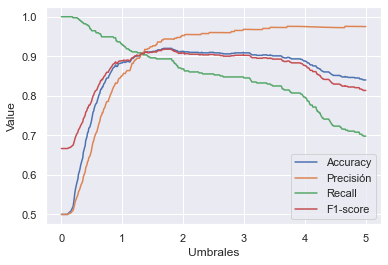

In [15]:
plt.plot(umbrales, accuracy, umbrales, precision, umbrales, recall, umbrales, f1)
plt.legend(["Accuracy", "Precisión", "Recall", "F1-score"])
plt.xlabel("Umbrales")
plt.ylabel("Value")

In [16]:
max_f1 = max(f1)
max_f1_index = f1.index(max_f1)
mejor_umbral = umbrales[max_f1_index]
print("Mejor umbral:", mejor_umbral)

Mejor umbral: 1.6800000000000013


## Evaluación e interpretación de resultados

En último lugar, se evalúan las distintas métricas sobre el conjunto de validación haciendo uso del umbral seleccionado. Por un lado, se observan métricas deseables que se pueden resumir en un F1-score igual a 0.92. Al validar tal información sobre la matriz de confusión se comprueba el rendimiento del clasificador sobre este conjunto ya que los datos se encuentran principalmente en la diagonal. 

--------------------------------------------------------
Reporte para el modelo sobre datos de validación
              precision    recall  f1-score   support

           0       0.90      0.95      0.92       394
           1       0.94      0.89      0.92       394

    accuracy                           0.92       788
   macro avg       0.92      0.92      0.92       788
weighted avg       0.92      0.92      0.92       788

--------------------------------------------------------


Text(54.260000000000005, 0.5, 'Etiquetas predichas')

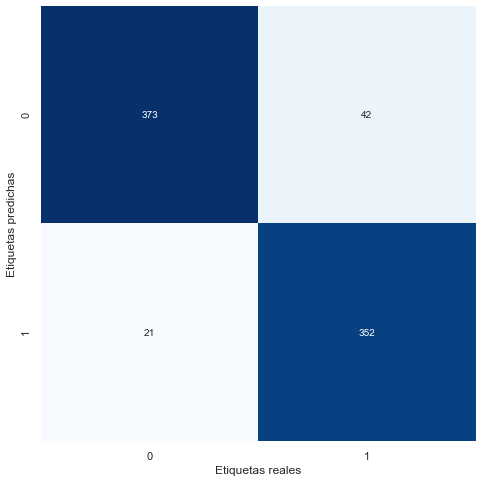

In [17]:
print('--------------------------------------------------------')
print('Reporte para el modelo sobre datos de validación')
y_pred_val = (squared_errors > mejor_umbral).astype(int)
print(classification_report(y_val, y_pred_val))
print('--------------------------------------------------------')
plt.figure(figsize=(8,8))
mat = confusion_matrix(y_val.to_numpy(), y_pred_val)
sns.heatmap(mat.T, square=True, annot=True, cmap='Blues', fmt='d', cbar=False)
plt.xlabel('Etiquetas reales')
plt.ylabel('Etiquetas predichas')

De esta manera, se procede a realizar la misma evaluación sobre datos que no han sido utilizados para la construcción del clasificador y que además conservan la distribución de datos original. Al analizar los resultados, se observan nuevamente métricas cercanas a 100% a excepción de la precisión de la clase 1. De acuerdo a la matriz de confusión, este error se da a causa de que el modelo llega a etiquetar como fraudulentas un número significativo de transacciones normales. A pesar de esto, como lo evidencia el recall, un alto porcentaje de las pocas transacciones fraudulentas logran ser detectadas.

Cabe resaltar que aunque el F1-score haya sido la métrica escogida para la selección del umbral por medio de los datos de validación, esta métrica sobre los datos de prueba de la clase positiva es muy baja. Lo anterior claramente se debe a que ahora se está calculando sobre la distribución orginal que presenta un gran desbalance. Por tanto, en este punto se debe prestar más atención al recall que permite evidenciar el desempeño de la detección de las anomalías.

In [18]:
squared_errors_test = []
for i in range(X_test.shape[0]):
    X_actual = X_test.iloc[i,:].to_frame().transpose()
    squared_errors_test.append(best_autoencoder['autoencoder'].model.evaluate(X_actual, X_actual, verbose=0))
squared_errors_test = np.array(squared_errors_test)
y_pred_test = (squared_errors_test > mejor_umbral).astype(int)

--------------------------------------------------------
Reporte para el modelo sobre datos de prueba
              precision    recall  f1-score   support

           0       1.00      0.95      0.97     56864
           1       0.03      0.86      0.05        98

    accuracy                           0.95     56962
   macro avg       0.51      0.90      0.51     56962
weighted avg       1.00      0.95      0.97     56962

--------------------------------------------------------


Text(54.260000000000005, 0.5, 'Etiquetas predichas')

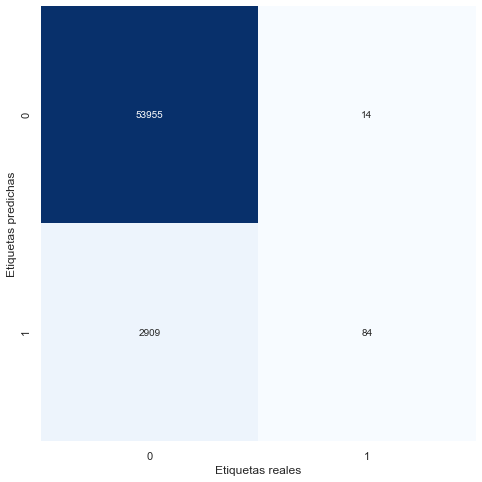

In [19]:
print('--------------------------------------------------------')
print('Reporte para el modelo sobre datos de prueba')
print(classification_report(y_test, y_pred_test))
print('--------------------------------------------------------')
plt.figure(figsize=(8,8))
mat = confusion_matrix(y_test.to_numpy(), y_pred_test)
sns.heatmap(mat.T, square=True, annot=True, cmap='Blues', fmt='d', cbar=False)
plt.xlabel('Etiquetas reales')
plt.ylabel('Etiquetas predichas')

## Conclusiones
- Considerando el desarrollo efectuado para la construcción de un detector de anomalías, es de destacar la versatilidad de aplicaciones con las que cuentan los autoencoders. Gracias a su capacidad de aprendizaje de la distribución propia de los datos, no solo logra llevar a cabo un proceso de reducción de dimensionalidad, sino que también posibilita la comparación implicita con distribuciones desconocidas a causa de la falta de datos.
- A la hora de realizar la selección del umbral de decisión, el balance de los datos juega un rol fundamental tomando en cuenta que el propósito principal corresponde a detectar anomalías. Por tal motivo, se debe garantizar dicho balance de manera que ambas clases sean consideradas con el mismo peso. De lo contrario, el modelo priorizaría tener un mejor F1-score a costa de que el recall se vea fuertemente disminuido.